In [2]:
# Environ
import scipy as scp
import tensorflow as tf
from scipy.stats import gamma
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.neighbors import KernelDensity
from statsmodels.distributions import ECDF
from basic_simulator import simulator
import random
import multiprocessing as mp
import psutil
import pickle
import os
import re
import time
from functools import partial
import seaborn as sns

# import dataset_generator as dg
# import make_data_lba as mdlba
# from tqdm import tqdm

# Own
#import ddm_data_simulation as ds
import cddm_data_simulation as cds
import kde_training_utilities as kde_util
import kde_class as kde
import boundary_functions as bf
from basic_simulator import *

from cdwiener import batch_fptd
from cdwiener import fptd


# Config -----
#[[-2.0, 2.0], [0.3, 2], [0.3, 0.7], [0.25, 2.25], [0.0, 0.4], [0, 0.5], [0.0, 0.25]]
#["v", "a", "w", "ndt", "dw", "sdv", "dndt"]
config = {'ddm': {'params':['v', 'a', 'w', 'ndt'],
                  'param_bounds': [[-2.7, 0.4, 0.15, 0.05], [2.7, 2.2, 0.85, 2.0]],
                 },
          'angle':{'params': ['v', 'a', 'w', 'ndt', 'theta'],
                   'param_bounds': [[-2.7, 0.4, 0.3, 0.1, - .1], [2.7, 1.7, 0.7, 1.9, np.pi / 2 - 0.3]],
                  },
          'weibull_cdf':{'params': ['v', 'a', 'w', 'ndt', 'alpha', 'beta'],
                         'param_bounds': [[-2.7, 0.3, 0.3, 0.1, 0.3, 0.3], [2.7, 1.7, 0.7, 1.9, 4.5, 6.5]]
                        },
          'levy':{'params':['v', 'a', 'w','alpha-diff', 'ndt'],
                  'param_bounds':[[-2.7, 0.4, 0.3, 1.1, 0.1], [2.7, 1.7, 0.7, 1.9, 1.9]]
                 },
          'ddm_sdv':{'params':['v', 'a', 'w', 'ndt', 'sdv'],
                     'param_bounds':[[-2.7, 0.5, 0.15, 0.05, 0.3],[2.7, 2.2, 0.85, 1.95, 2.2]]
                    },
          'full_ddm':{'params':['v', 'a', 'w', 'ndt', 'dw', 'sdv', 'dndt'],
                      'param_bounds':[[-2.5, 0.4, 0.25, 0.3, 0.05 , 0.05, 0.05],[2.5, 1.8, 0.65, 2.2, 0.35, 0.45, 0.25]]
                     },
         }

In [8]:
out = simulator(theta = np.tile([1.0, 1.5, 2.0, 2.0, 1.5, 0.5, 0.3, 0.6, 0.5, 0.5], (10, 1)),
          model = 'race_model_4',
          n_samples = 10000,
          n_trials = 10,
          max_t = 20)

In [ ]:
["v_0", "v_1", "v_2", "a", "w_0", "w_1", "w_2", "ndt"]

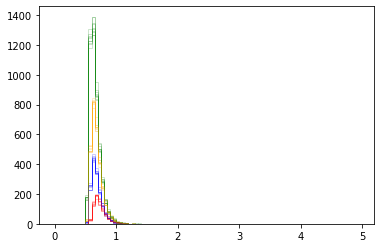

In [10]:
n_trials = 10
for i in range(n_trials):
    plt.hist(out[0][out[1][:, i, 0] == 0, i, :], bins = np.arange(0, 5, 0.05), alpha = 0.2, color = 'blue', histtype = 'step')
    plt.hist(out[0][out[1][:, i, 0] == 1, i, :], bins = np.arange(0, 5, 0.05), alpha = 0.2, color = 'red', histtype = 'step')
    plt.hist(out[0][out[1][:, i, 0] == 2, i, :], bins = np.arange(0, 5, 0.05), alpha = 0.2, color = 'green', histtype = 'step')
    plt.hist(out[0][out[1][:, i, 0] == 3, i, :], bins = np.arange(0, 5, 0.05), alpha = 0.2, color = 'orange', histtype = 'step')

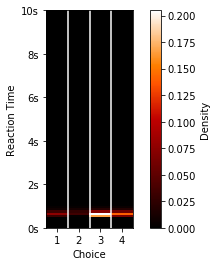

In [13]:
# cmap = matplotlib.colors.Colormap('greys')
dat = np.hstack([out[0][:, 0], out[1][:, 0]])
x, binx, biny = np.histogram2d(dat[:, 0], dat[:, 1], bins = [np.linspace(0, 10, 100), [0, 1, 2, 3, 4]])
x = x / np.sum(x)

plt.clf()
plt.imshow(x, extent = [biny[0], biny[-1], binx[0], binx[-1]], origin = 'lower', cmap = plt.get_cmap('gist_heat'), interpolation = None)
plt.vlines(x = 1, ymin = 0, ymax = 10, colors = 'white')
plt.vlines(x = 2, ymin = 0, ymax = 10, colors = 'white')
plt.vlines(x = 3, ymin = 0, ymax = 10, colors = 'white')
plt.xticks([0.5, 1.5, 2.5, 3.5], ['1', '2', '3', '4'])
plt.yticks([0, 2, 4, 6, 8, 10], ['0s', '2s', '4s', '6s', '8s', '10s'])
plt.ylabel('Reaction Time')
plt.xlabel('Choice')
plt.colorbar(label = 'Density')

In [14]:
x

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [3.180e-02, 3.100e-03, 1.667e-01, 6.410e-02],
       [7.660e-02, 3.420e-02, 2.049e-01, 1.403e-01],
       [3.340e-02, 2.580e-02, 7.180e-02, 5.930e-02],
       [9.400e-03, 1.150e-02, 1.960e-02, 1.900e-02],
       [3.600e-03, 3.400e-03, 7.100e-03, 5.700e-03],
       [8.000e-04, 9.000e-04, 1.500e-03, 1.600e-03],
       [3.000e-04, 5.000e-04, 5.000e-04, 1.000e-03],
       [0.000e+00, 2.000e-04, 4.000e-04, 1.000e-04],
       [1.000e-04, 0.000e+00, 3.000e-04, 2.000e-04],
       [0.000e+00, 0.000e+00, 0.000e+00, 2.000e-04],
       [0.000e+00, 0.000e+00, 0.000e+00, 1.000e-04],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000

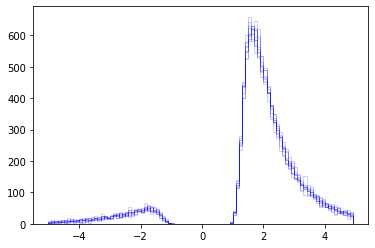

In [17]:
n_trials = 10
for i in range(n_trials):
    plt.hist(out[0][:, i, :] * out[1][:, i, :], bins = np.arange(-5, 5, 0.1), alpha = 0.2, color = 'blue', histtype = 'step')
#plt.hist(out2[0] * out2[1], bins = np.arange(-5, 5, 0.1), alpha = 0.2, color = 'red')

In [ ]:
simulator(theta = np.tile([0.5, 1.5, 0.5, 0.5, 3.0, 3.0], (10, 1)),
          model = 'weibull_cdf',
          n_samples = 10000,
          n_trials = 10,
          max_t = 20)

In [2]:
# Config -----
#[[-2.0, 2.0], [0.3, 2], [0.3, 0.7], [0.25, 2.25], [0.0, 0.4], [0, 0.5], [0.0, 0.25]]
#["v", "a", "w", "ndt", "dw", "sdv", "dndt"]
config = {'ddm': {'params':['v', 'a', 'w', 'ndt'],
                  'param_bounds': [[-2.7, 0.4, 0.15, 0.05], [2.7, 2.2, 0.85, 2.0]],
                 },
          'angle':{'params': ['v', 'a', 'w', 'ndt', 'theta'],
                   'param_bounds': [[-2.7, 0.4, 0.3, 0.1, - .1], [2.7, 1.7, 0.7, 1.9, np.pi / 2 - 0.3]],
                  },
          'weibull_cdf':{'params': ['v', 'a', 'w', 'ndt', 'alpha', 'beta'],
                         'param_bounds': [[-2.7, 0.3, 0.3, 0.1, 0.3, 0.3], [2.7, 1.7, 0.7, 1.9, 4.5, 6.5]]
                        },
          'levy':{'params':['v', 'a', 'w','alpha-diff', 'ndt'],
                  'param_bounds':[[-2.7, 0.4, 0.3, 1.1, 0.1], [2.7, 1.7, 0.7, 1.9, 1.9]]
                 },
          'ddm_sdv':{'params':['v', 'a', 'w', 'ndt', 'sdv'],
                     'param_bounds':[[-2.7, 0.5, 0.15, 0.05, 0.3],[2.7, 2.2, 0.85, 1.95, 2.2]]
                    },
          'full_ddm':{'params':['v', 'a', 'w', 'ndt', 'dw', 'sdv', 'dndt'],
                      'param_bounds':[[-2.5, 0.4, 0.25, 0.3, 0.05 , 0.05, 0.05],[2.5, 1.8, 0.65, 2.2, 0.35, 0.45, 0.25]]
                     },
         }

In [3]:
t_vec = []
for i in range(10):
    start = time.time()
    out1 = cds.ddm_sdv(v = 0,
                       a =  1, 
                       w =  0.5, 
                       ndt =  0.5,
                       sdv = 0.0,
                       n_samples = 100000, 
                       boundary_fun = bf.constant)
    print(i)
    t_vec.append((time.time() - start))

TypeError: Argument 'v' has incorrect type (expected numpy.ndarray, got int)

In [2]:
t_vec1 = []
for i in range(10):
    start = time.time()
    out1 = cds.ddm_flexbound(v = np.array([0.0], dtype = np.float32),
                             a =  np.array([1.0], dtype = np.float32), 
                             w =  np.array([0.5], dtype = np.float32), 
                             ndt =  np.array([0.5], dtype = np.float32),
                             n_samples = 100000,
                             boundary_fun = bf.weibull_cdf,
                             boundary_params = {'alpha': np.array([3.0], dtype = np.float32), 'beta': np.array([2.0], dtype = np.float32)})
    print(i)
    t_vec1.append((time.time() - start))

0
1


KeyboardInterrupt: 

In [177]:
t_vec1 = []
theta = np.asarray([0, 1, 0.5, 0.5], dtype = np.float32)
for i in range(10):
    start = time.time()
    out1 = cds.ddm_flexbound(v = theta[[0]],
                             a =  theta[[1]], 
                             w =  theta[[2]], 
                             ndt =  theta[[3]],
                             n_samples = 100000,
                             boundary_fun = bf.weibull_cdf,
                             boundary_params = {'alpha': np.array([3.0], dtype = np.float32), 'beta': np.array([2.0], dtype = np.float32)})
    print(i)
    t_vec1.append((time.time() - start))

0
1
2
3
4
5
6
7
8
9


In [2]:
t_vec1 = []
n_trials = 10
for i in range(10):
    start = time.time()
    out1 = cds.levy_flexbound(v = np.repeat(0.0, n_trials).astype(np.float32),
                              a =  np.repeat(1.0, n_trials).astype(np.float32), 
                              w =  np.repeat(0.5, n_trials).astype(np.float32), 
                              ndt =  np.repeat(0.5, n_trials).astype(np.float32),
                              alpha_diff = np.repeat(1.5, n_trials).astype(np.float32),
                              n_samples = 10000,
                              n_trials = n_trials,
                              boundary_fun = bf.weibull_cdf,
                              boundary_params = {'alpha': np.repeat(3.0, n_trials).astype(np.float32), 'beta': np.repeat(2.0, n_trials).astype(np.float32)})
    print(i)
    t_vec1.append((time.time() - start))

0
1
2
3
4
5
6
7
8
9


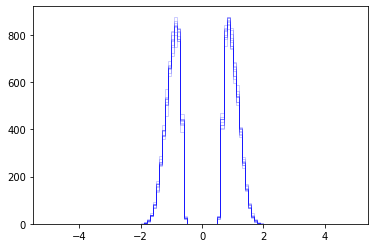

In [10]:
for i in range(n_trials):
    plt.hist(out1[0][:, i, :] * out1[1][:, i, :], bins = np.arange(-5, 5, 0.1), alpha = 0.2, color = 'blue', histtype = 'step')
#plt.hist(out2[0] * out2[1], bins = np.arange(-5, 5, 0.1), alpha = 0.2, color = 'red')

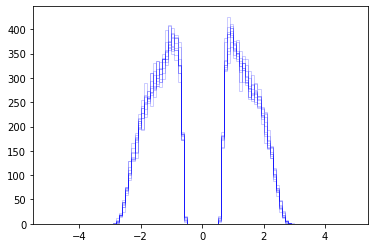

In [8]:
for i in range(n_trials):
    plt.hist(out1[0][:, i, :] * out1[1][:, i, :], bins = np.arange(-5, 5, 0.1), alpha = 0.2, color = 'blue', histtype = 'step')
#plt.hist(out2[0] * out2[1], bins = np.arange(-5, 5, 0.1), alpha = 0.2, color = 'red')

In [9]:
t_vec1 = []
n_trials = 10
for i in range(10):
    start = time.time()
    out1 = cds.ornstein_uhlenbeck(v = np.repeat(0.0, n_trials).astype(np.float32),
                                  a =  np.repeat(1.0, n_trials).astype(np.float32), 
                                  w =  np.repeat(0.5, n_trials).astype(np.float32), 
                                  ndt =  np.repeat(0.5, n_trials).astype(np.float32),
                                  g = np.repeat(0.5, n_trials).astype(np.float32),
                                  n_samples = 10000,
                                  n_trials = n_trials,
                                  boundary_fun = bf.weibull_cdf,
                                  boundary_params = {'alpha': np.repeat(1.0, n_trials).astype(np.float32), 'beta': np.repeat(1.0, n_trials).astype(np.float32)})
    print(i)
    t_vec1.append((time.time() - start))

0
1
2
3
4
5
6
7
8
9


In [3]:
t_vec1

[1.9787018299102783,
 2.084127902984619,
 2.2693300247192383,
 2.3534820079803467,
 2.4157869815826416,
 2.4646248817443848,
 2.534605026245117,
 2.6075236797332764,
 2.8428049087524414,
 2.886561155319214]

In [2]:
t_vec1 = []
n_trials = 10
for i in range(10):
    start = time.time()
    out1 = cds.ornstein_uhlenbeck(v = np.repeat(0.0, n_trials).astype(np.float32),
                                  a =  np.repeat(1.0, n_trials).astype(np.float32), 
                                  w =  np.repeat(0.5, n_trials).astype(np.float32), 
                                  ndt =  np.repeat(0.5, n_trials).astype(np.float32),
                                  g = np.repeat(-0.0, n_trials).astype(np.float32),
                                  n_samples = 10000,
                                  n_trials = n_trials,
                                  boundary_fun = bf.weibull_cdf,
                                  boundary_params = {'alpha': np.repeat(3.0, n_trials).astype(np.float32), 'beta': np.repeat(2.0, n_trials).astype(np.float32)})
    print(i)
    t_vec1.append((time.time() - start))

0
1
2
3
4
5
6
7
8
9


In [158]:
t_vec1 = []
n_trials = 10
for i in range(10):
    start = time.time()
    out1 = cds.race_model(v = np.tile([0.0, 1.0, 2.0], (n_trials, 1)).astype(np.float32),
                          a =  np.tile(np.expand_dims(np.repeat(1.0, n_trials).astype(np.float32), axis = 1), (1, 1)), 
                          w =  np.tile(np.expand_dims(np.repeat(0.5, n_trials).astype(np.float32), axis = 1), (1,3)), 
                          ndt =  np.tile(np.expand_dims(np.repeat(0.5, n_trials).astype(np.float32), axis = 1), (1,1)),
                          s = np.tile(np.expand_dims(np.repeat(1.0, n_trials).astype(np.float32), axis = 1), (1,3)),
                          n_samples = 10000,
                          n_trials = n_trials,
                          boundary_fun = bf.weibull_cdf,
                          boundary_params = {'alpha': np.repeat(3.0, n_trials).astype(np.float32), 'beta': np.repeat(2.0, n_trials).astype(np.float32)})
    print(i)
    t_vec1.append((time.time() - start))

0
1
2
3
4
5
6
7
8
9


In [157]:
np.tile([0.0, 1.0, 2.0], (n_trials, 1)).astype(np.float32)

(10, 3)

In [153]:
np.repeat([0.0, 1.0, 2.0], n_trials)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

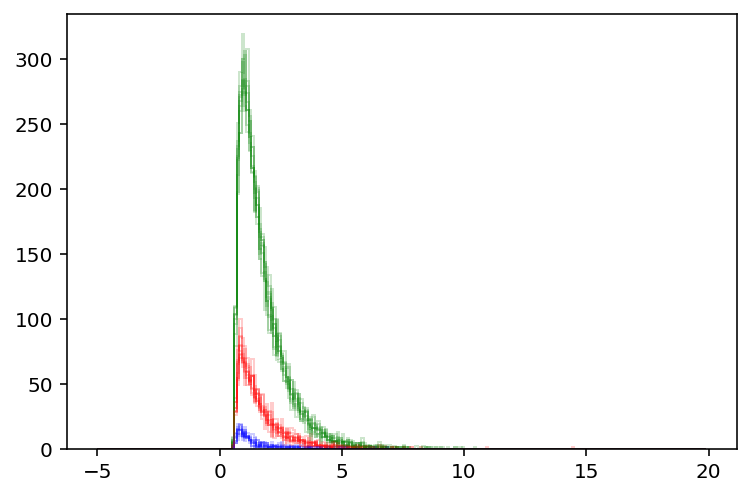

In [173]:
for i in range(n_trials):
    plt.hist(out1[0][out1[1][:, i, 0] == 0, i, :], bins = np.arange(-5, 20, 0.1), alpha = 0.2, color = 'blue', histtype = 'step')
    plt.hist(out1[0][out1[1][:, i, 0] == 1, i, :], bins = np.arange(-5, 20, 0.1), alpha = 0.2, color = 'red', histtype = 'step')
    plt.hist(out1[0][out1[1][:, i, 0] == 2, i, :], bins = np.arange(-5, 20, 0.1), alpha = 0.2, color = 'green', histtype = 'step')

#plt.hist(out2[0] * out2[1], bins = np.arange(-5, 5, 0.1), alpha = 0.2, color = 'red')

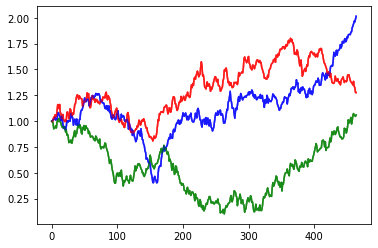

In [27]:
for i in range(n_trials):
    plt.plot(out1[2]['trajectory'][:, 0][out1[2]['trajectory'][:, 0] > -999], alpha = 0.2, color = 'blue')
    plt.plot(out1[2]['trajectory'][:, 1][out1[2]['trajectory'][:, 1] > -999], alpha = 0.2, color = 'red')
    plt.plot(out1[2]['trajectory'][:, 2][out1[2]['trajectory'][:, 2] > -999], alpha = 0.2, color = 'green')


In [36]:
heatm, xedges, yedges = np.histogram2d(np.hstack([out1[0][:, 0], out1[1][:, 0]]))


(1000, 2)

In [55]:
import matplotlib

In [165]:
# cmap = matplotlib.colors.Colormap('greys')
dat = np.hstack([out1[0][:, 0], out1[1][:, 0]])
x, binx, biny = np.histogram2d(dat[:, 0], dat[:, 1], bins = [np.linspace(0, 10, 50), [0, 1, 2, 3]])
x = x / np.sum(x)

In [123]:
np.sum(x)

1000.0

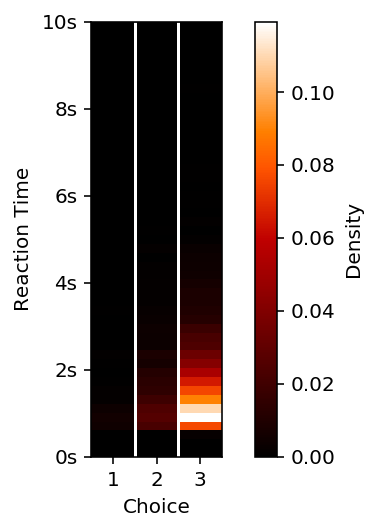

In [172]:
plt.clf()
plt.imshow(x, extent = [biny[0], biny[-1], binx[0], binx[-1]], origin = 'lower', cmap = plt.get_cmap('gist_heat'), interpolation = None)
plt.vlines(x = 1, ymin = 0, ymax = 10, colors = 'white')
plt.vlines(x = 2, ymin = 0, ymax = 10, colors = 'white')
plt.xticks([0.5, 1.5, 2.5], ['1', '2', '3'])
plt.yticks([0, 2, 4, 6, 8, 10], ['0s', '2s', '4s', '6s', '8s', '10s'])
plt.ylabel('Reaction Time')
plt.xlabel('Choice')
plt.colorbar(label = 'Density')

In [ ]:
for i in range(n_trials):
    plt.hist(out1[0][out1[1][:, i, 0] == 0, i, :], bins = np.arange(-5, 20, 0.1), alpha = 0.2, color = 'blue', histtype = 'step')
    plt.hist(out1[0][out1[1][:, i, 0] == 1, i, :], bins = np.arange(-5, 20, 0.1), alpha = 0.2, color = 'red', histtype = 'step')
    plt.hist(out1[0][out1[1][:, i, 0] == 2, i, :], bins = np.arange(-5, 20, 0.1), alpha = 0.2, color = 'green', histtype = 'step')

#plt.hist(out2[0] * out2[1], bins = np.arange(-5, 5, 0.1), alpha = 0.2, color = 'red')

(array([[  0.,  53., 137.,  74.,  34.,  15.,   9.,   8.,   5.,   1.,   0.,
           0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.],
        [  0.,  70., 126.,  67.,  43.,  18.,  11.,   4.,   3.,   1.,   1.,
           1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.],
        [  0.,  58., 131.,  63.,  28.,  22.,  10.,   1.,   2.,   0.,   1.,
           0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,

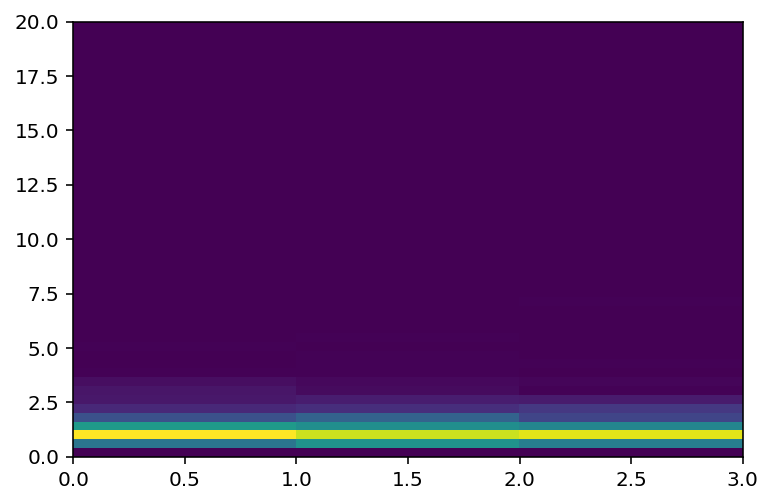

In [67]:
plt.hist2d(x = dat[:,1], y = dat[:,0], bins = [[0, 1, 2, 3], np.linspace(0, 20, 50)])# cmap = cmap, norm = matplotlib.colors.Normalize())

In [46]:
np.linspace(0,20, 256)

array([ 0.        ,  0.07843137,  0.15686275,  0.23529412,  0.31372549,
        0.39215686,  0.47058824,  0.54901961,  0.62745098,  0.70588235,
        0.78431373,  0.8627451 ,  0.94117647,  1.01960784,  1.09803922,
        1.17647059,  1.25490196,  1.33333333,  1.41176471,  1.49019608,
        1.56862745,  1.64705882,  1.7254902 ,  1.80392157,  1.88235294,
        1.96078431,  2.03921569,  2.11764706,  2.19607843,  2.2745098 ,
        2.35294118,  2.43137255,  2.50980392,  2.58823529,  2.66666667,
        2.74509804,  2.82352941,  2.90196078,  2.98039216,  3.05882353,
        3.1372549 ,  3.21568627,  3.29411765,  3.37254902,  3.45098039,
        3.52941176,  3.60784314,  3.68627451,  3.76470588,  3.84313725,
        3.92156863,  4.        ,  4.07843137,  4.15686275,  4.23529412,
        4.31372549,  4.39215686,  4.47058824,  4.54901961,  4.62745098,
        4.70588235,  4.78431373,  4.8627451 ,  4.94117647,  5.01960784,
        5.09803922,  5.17647059,  5.25490196,  5.33333333,  5.41

In [160]:
t_vec1 = []
n_trials = 10
for i in range(10):
    start = time.time()
t_vec1 = []
n_trials = 10
for i in range(10):
    start = time.time()
    out1 = cds.lca(v =  np.tile([0.0, 1.0, 2.0], (n_trials, 1)).astype(np.float32),
                    a =  np.tile(np.expand_dims(np.repeat(2.0, n_trials).astype(np.float32), axis = 1), (1, 1)), 
                    w =  np.tile(np.expand_dims(np.repeat(0.5, n_trials).astype(np.float32), axis = 1), (1,3)), 
                    ndt =  np.tile(np.expand_dims(np.repeat(0.5, n_trials).astype(np.float32), axis = 1), (1,1)),
                    b = np.tile(np.expand_dims(np.repeat(0.8, n_trials).astype(np.float32), axis = 1), (1,3)),
                    g = np.tile(np.expand_dims(np.repeat(0.5, n_trials).astype(np.float32), axis = 1), (1,3)),
                    s = np.tile(np.expand_dims(np.repeat(1.0, n_trials).astype(np.float32), axis = 1), (1,3)),
                    n_samples = 5000,
                    n_trials = n_trials,
                    boundary_fun = bf.constant,
                    boundary_params ={})# {'alpha': np.repeat(3.0, n_trials).astype(np.float32), 'beta': np.repeat(2.0, n_trials).astype(np.float32)})
    print(i)
    t_vec1.append((time.time() - start))

0
1
2
3
4
5
6
7
8
9


74     ],
       [0.52      ],
       [0.543     ],
       [0.548     ],
       [0.551     ],
       [0.57299995],
       [0.566     ],
       [0.70900023],
       [0.596     ],
       [0.574     ],
       [0.524     ],
       [0.532     ],
       [0.543     ],
       [0.538     ],
       [0.63800013],
       [0.562     ],
       [0.64700013],
       [0.53000003],
       [0.529     ],
       [0.522     ],
       [0.6480001 ],
       [0.61500007],
       [0.532     ],
       [0.64700013],
       [0.533     ],
       [0.6140001 ],
       [0.6900002 ],
       [0.61100006],
       [0.548     ],
       [0.532     ],
       [0.522     ],
       [0.64600015],
       [0.524     ],
       [0.55499995],
       [0.6220001 ],
       [0.551     ],
       [0.56099993],
       [0.55599993],
       [0.7140002 ],
       [0.66500014],
       [0.567     ],
       [0.60300004],
       [0.54999995],
       [0.63400006],
       [0.567     ],
       [0.579     ],
       [0.55899996],
       [0.582     ],
   

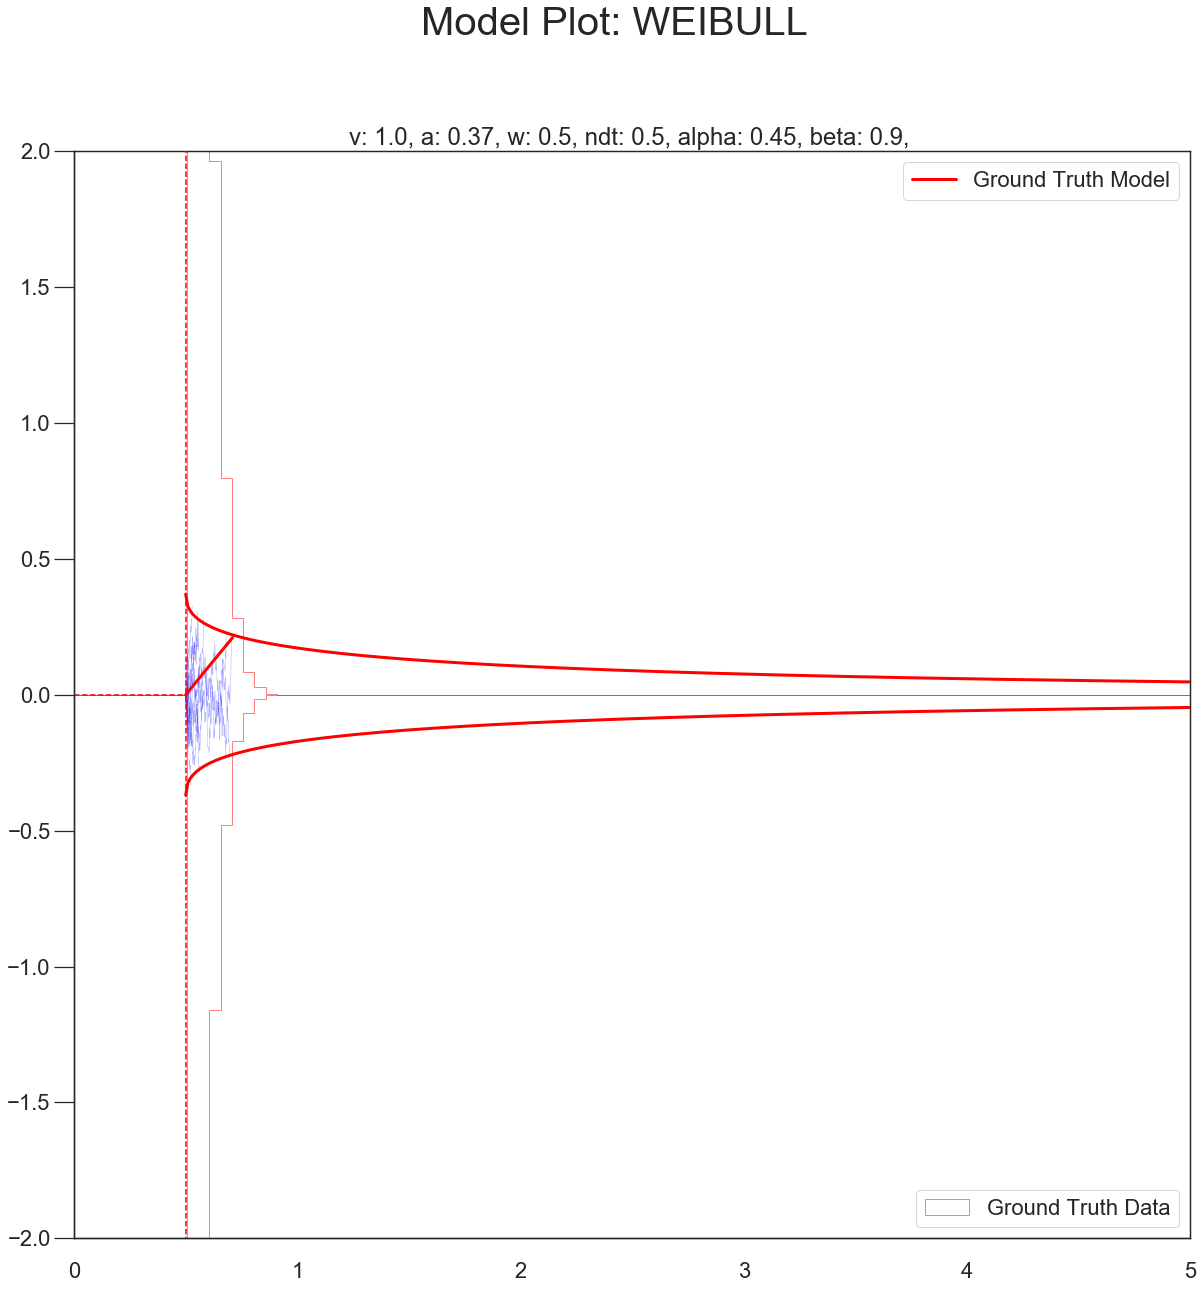

In [5]:
model_plot(model = 'weibull_cdf',
           ground_truths = [1.0, 0.37, 0.5, 0.5, 0.45, 0.9],
           cols = 1,
           n_plots = 1,
           save = False,
           show = True,
           plot_format = 'png')

In [3]:
def model_plot(posterior_samples = None,
               ground_truths = [],
               cols = 3,
               model = 'weibull_cdf',
               n_post_params = 500,
               n_plots = 4,
               samples_by_param = 10,
               max_t = 5,
               input_hddm_trace = False,
               datatype = 'single_subject', # 'hierarchical', 'single_subject', 'condition'
               show_model = True,
               show = False,
               save = False,
               machine = 'home',
               data_signature = '',
               train_data_type = '',
               method = 'cnn',
               plot_format = 'svg'):
    
    #matplotlib.rcParams['text.usetex'] = True
    #matplotlib.rcParams['pdf.fonttype'] = 42
    #matplotlib.rcParams['svg.fonttype'] = 'none'
    
    if 'weibull_cdf' in model:
        model = 'weibull_cdf'
    if 'angle' in model:
        model = 'angle'
    
    # Inputs are hddm_traces --> make plot ready
    if input_hddm_trace and posterior_samples is not None:
        if datatype == 'hierarchical':
            posterior_samples = _make_trace_plotready_hierarchical(posterior_samples, 
                                                                   model = model)
            n_plots = posterior_samples.shape[0]
#             print(posterior_samples)
            
        if datatype == 'single_subject':
            posterior_samples = _make_trace_plotready_single_subject(posterior_samples, 
                                                                     model = model)
        if datatype == 'condition':
            posterior_samples = _make_trace_plotready_condition(posterior_samples, 
                                                                model = model)
            n_plots = posterior_samples.shape[0]
            #print(posterior_samples)
            #n_plots = posterior_samples.shape[0]

    tmp_simulator = partial(simulator, 
                            model = model, 
                            delta_t = 0.001, 
                            max_t = 20, 
                            bin_dim = 0)

    # Taking care of special case with 1 plot
    if n_plots == 1:
        ground_truths = np.expand_dims(ground_truths, 0)
        if posterior_samples is not None:
            posterior_samples = np.expand_dims(posterior_samples, 0)
            
    plot_titles = {'ddm': 'DDM', 
                   'angle': 'ANGLE',
                   'full_ddm': 'FULL DDM',
                   'weibull_cdf': 'WEIBULL',
                   'levy': 'LEVY',
                   'ornstein': 'ORNSTEIN UHLENBECK',
                   'ddm_sdv': 'DDM RANDOM SLOPE',
                  }
    
    title = 'Model Plot: '
    ax_titles = config[model]['params']

    rows = int(np.ceil(n_plots / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    
    my_suptitle = fig.suptitle(title + plot_titles[model], fontsize = 40)
    sns.despine(right = True)
    
    t_s = np.arange(0, max_t, 0.01)
    
    for i in range(n_plots):
        print('Making plot: ', i)
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        if rows > 1 and cols > 1:
            ax[row_tmp, col_tmp].set_xlim(0, max_t)
            ax[row_tmp, col_tmp].set_ylim(-2, 2)
        elif (rows == 1 and cols > 1) or (rows > 1 and cols == 1):
            ax[i].set_xlim(0, max_t)
            ax[i].set_ylim(-2, 2)
        else:
            ax.set_xlim(0, max_t)
            ax.set_ylim(-2, 2)


        # Run simulations and add trajectories
        for k in range(10):
            out = tmp_simulator(theta = ground_truths[i, :])
            print(out)
            if rows > 1 and cols > 1:
                ax[row_tmp, col_tmp].plot(out[2]['ndt'] + np.arange(0, out[2]['max_t'] +  out[2]['delta_t'], out[2]['delta_t'])[out[2]['trajectory'][:, 0] > -999], out[2]['trajectory'][out[2]['trajectory'] > -999], color = 'red', alpha = 0.05)
            elif (rows == 1 and cols > 1) or (rows > 1 and cols == 1):
                ax[i].plot(out[2]['ndt'] + np.arange(0, out[2]['max_t'] +  out[2]['delta_t'], out[2]['delta_t'])[out[2]['trajectory'][:, 0] > -999], out[2]['trajectory'][out[2]['trajectory'] > -999], color = 'red', alpha = 0.1)
            else:
                ax.plot(out[2]['ndt'] + np.arange(0, out[2]['max_t'] +  out[2]['delta_t'], out[2]['delta_t'])[out[2]['trajectory'][:, 0] > -999], out[2]['trajectory'][out[2]['trajectory'] > -999], color = 'blue', alpha = 0.3, linewidth = 0.5)
                #ax_ins = ax.inset_axes([1, 0.5, 0.2, 0.2])
                #ax_ins.plot([0, 1, 2, 3])
        # Run simulations and add histograms
        # True params
        print('Running ground truth simulator: ')
        out = tmp_simulator(theta = ground_truths[i, :],
                            n_samples = 20000)
        
        print('Simulator finished')
        tmp_true = np.concatenate([out[0], out[1]], axis = 1)
        choice_p_up_true = np.sum(tmp_true[:, 1] == 1) / tmp_true.shape[0]
        
        if posterior_samples is not None:
            # Run Model simulations for posterior samples
            tmp_post = np.zeros((n_post_params * samples_by_param, 2))
            idx = np.random.choice(posterior_samples.shape[1], size = n_post_params, replace = False)
            
            print('Running posterior simulator: ')
            for j in range(n_post_params):
                
                out = tmp_simulator(theta = posterior_samples[i, idx[j], :],
                                   n_samples = samples_by_param)
                                
                tmp_post[(samples_by_param * j):(samples_by_param * (j + 1)), :] = np.concatenate([out[0], out[1]], axis = 1)
            print('Posterior simulator finished')
            
         #ax.set_ylim(-4, 2)
        if rows > 1 and cols > 1:
            ax_tmp = ax[row_tmp, col_tmp].twinx()
        elif (rows == 1 and cols > 1) or (rows > 1 and cols == 1):
            ax_tmp = ax[i].twinx()
        else:
            ax_tmp = ax.twinx()
        
        ax_tmp.set_ylim(-2, 2)
        ax_tmp.set_yticks([])
        
        if posterior_samples is not None:
            choice_p_up_post = np.sum(tmp_post[:, 1] == 1) / tmp_post.shape[0]



            counts, bins = np.histogram(tmp_post[tmp_post[:, 1] == 1, 0],
                                        bins = np.linspace(0, max_t, 100))

            counts_2, bins = np.histogram(tmp_post[tmp_post[:, 1] == 1, 0],
                                          bins = np.linspace(0, max_t, 100),
                                          density = True)
            
            if j == (n_post_params - 1) and row_tmp == 0 and col_tmp == 0:
                ax_tmp.hist(bins[:-1], 
                            bins, 
                            weights = choice_p_up_post * counts_2,
                            histtype = 'step',
                            alpha = 0.5, 
                            color = 'black',
                            edgecolor = 'black',
                            zorder = -1,
                            label = 'Posterior Predictive')
                
            else:
                ax_tmp.hist(bins[:-1], 
                            bins, 
                            weights = choice_p_up_post * counts_2,
                            histtype = 'step',
                            alpha = 0.5, 
                            color = 'black',
                            edgecolor = 'black',
                            zorder = -1)
                        
        counts, bins = np.histogram(tmp_true[tmp_true[:, 1] == 1, 0],
                                bins = np.linspace(0, max_t, 100))

        counts_2, bins = np.histogram(tmp_true[tmp_true[:, 1] == 1, 0],
                                      bins = np.linspace(0, max_t, 100),
                                      density = True)
        
        if row_tmp == 0 and col_tmp == 0:
            ax_tmp.hist(bins[:-1], 
                        bins, 
                        weights = choice_p_up_true * counts_2,
                        histtype = 'step',
                        alpha = 0.5, 
                        color = 'red',
                        edgecolor = 'red',
                        zorder = -1,
                        label = 'Ground Truth Data')
            ax_tmp.legend(loc = 'lower right')
        else:
            ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = choice_p_up_true * counts_2,
                    histtype = 'step',
                    alpha = 0.5, 
                    color = 'red',
                    edgecolor = 'red',
                    zorder = -1)
             
        #ax.invert_xaxis()
        if rows > 1 and cols > 1:
            ax_tmp = ax[row_tmp, col_tmp].twinx()
        elif (rows == 1 and cols > 1) or (rows > 1 and cols == 1):
            ax_tmp = ax[i].twinx()
        else:
            ax_tmp = ax.twinx()
            
        ax_tmp.set_ylim(2, -2)
        ax_tmp.set_yticks([])
        
        if posterior_samples is not None:
            counts, bins = np.histogram(tmp_post[tmp_post[:, 1] == -1, 0],
                            bins = np.linspace(0, max_t, 100))

            counts_2, bins = np.histogram(tmp_post[tmp_post[:, 1] == -1, 0],
                                          bins = np.linspace(0, max_t, 100),
                                          density = True)
            ax_tmp.hist(bins[:-1], 
                        bins, 
                        weights = (1 - choice_p_up_post) * counts_2,
                        histtype = 'step',
                        alpha = 0.5, 
                        color = 'black',
                        edgecolor = 'black',
                        zorder = -1)
        
        counts, bins = np.histogram(tmp_true[tmp_true[:, 1] == -1, 0],
                                    bins = np.linspace(0, max_t, 100))
    
        counts_2, bins = np.histogram(tmp_true[tmp_true[:, 1] == -1, 0],
                                      bins = np.linspace(0, max_t, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = (1 - choice_p_up_true) * counts_2,
                    histtype = 'step',
                    alpha = 0.5, 
                    color = 'red',
                    edgecolor = 'red',
                    zorder = -1)
        
        # Plot posterior samples of bounds and slopes (model)
        print('Making bounds')
        if show_model:
            if posterior_samples is not None:
                for j in range(n_post_params):
                    if model == 'weibull_cdf' or model == 'weibull_cdf2':
                        b = posterior_samples[i, idx[j], 1] * bf.weibull_cdf(t = t_s, 
                                                                             alpha = posterior_samples[i, idx[j], 4],
                                                                             beta = posterior_samples[i, idx[j], 5])
                    if model == 'angle' or model == 'angle2':
                        b = np.maximum(posterior_samples[i, idx[j], 1] + bf.angle(t = t_s, 
                                                                                  theta = posterior_samples[i, idx[j], 4]), 0)
                    if model == 'ddm':
                        b = posterior_samples[i, idx[j], 1] * np.ones(t_s.shape[0])


                    start_point_tmp = - posterior_samples[i, idx[j], 1] + \
                                      (2 * posterior_samples[i, idx[j], 1] * posterior_samples[i, idx[j], 2])

                    slope_tmp = posterior_samples[i, idx[j], 0]

                    if rows > 1 and cols > 1:
                        ax[row_tmp, col_tmp].plot(t_s + posterior_samples[i, idx[j], 3], b, 'black',
                                                  t_s + posterior_samples[i, idx[j], 3], - b, 'black', 
                                                  alpha = 0.05,
                                                  zorder = 1000)
                    elif (rows == 1 and cols > 1) or (rows > 1 and cols == 1):
                        ax[i].plot(t_s + posterior_samples[i, idx[j], 3], b, 'black',
                                   t_s + posterior_samples[i, idx[j], 3], - b, 'black', 
                                   alpha = 0.05,
                                   zorder = 1000)
                    else:
                        ax.plot(t_s + posterior_samples[i, idx[j], 3], b, 'black',
                                t_s + posterior_samples[i, idx[j], 3], - b, 'black', 
                                alpha = 0.05,
                                zorder = 1000)
                    

                    for m in range(len(t_s)):
                        if (start_point_tmp + (slope_tmp * t_s[m])) > b[m] or (start_point_tmp + (slope_tmp * t_s[m])) < -b[m]:
                            maxid = m
                            break
                        maxid = m

                    if rows > 1 and cols > 1:
                        ax[row_tmp, col_tmp].plot(t_s[:maxid] + posterior_samples[i, idx[j], 3],
                                                  start_point_tmp + slope_tmp * t_s[:maxid], 
                                                  'black', 
                                                  alpha = 0.05,
                                                  zorder = 1000)
                        if j == (n_post_params - 1):
                            ax[row_tmp, col_tmp].plot(t_s[:maxid] + posterior_samples[i, idx[j], 3],
                                                      start_point_tmp + slope_tmp * t_s[:maxid], 
                                                      'black', 
                                                      alpha = 0.05,
                                                      zorder = 1000,
                                                      label = 'Model Samples')
                    elif (rows == 1 and cols > 1) or (rows > 1 and cols == 1):
                        ax[i].plot(t_s[:maxid] + posterior_samples[i, idx[j], 3],
                                   start_point_tmp + slope_tmp * t_s[:maxid], 
                                   'black', 
                                   alpha = 0.05,
                                   zorder = 1000)
                        if j == (n_post_params - 1):
                            ax[i].plot(t_s[:maxid] + posterior_samples[i, idx[j], 3],
                                       start_point_tmp + slope_tmp * t_s[:maxid], 
                                       'black', 
                                       alpha = 0.05,
                                       zorder = 1000,
                                       label = 'Model Samples')

                    else:
                        ax.plot(t_s[:maxid] + posterior_samples[i, idx[j], 3],
                                start_point_tmp + slope_tmp * t_s[:maxid], 
                                'black', 
                                alpha = 0.05,
                                zorder = 1000)
                        if j ==(n_post_params - 1):
                            ax.plot(t_s[:maxid] + posterior_samples[i, idx[j], 3],
                                    start_point_tmp + slope_tmp * t_s[:maxid], 
                                    'black', 
                                    alpha = 0.05,
                                    zorder = 1000,
                                    label = 'Model Samples')
                            
                            
                    if rows > 1 and cols > 1:
                        ax[row_tmp, col_tmp].axvline(x = posterior_samples[i, idx[j], 3], 
                                                     ymin = - 2, 
                                                     ymax = 2, 
                                                     c = 'black', 
                                                     linestyle = '--',
                                                     alpha = 0.05)
                        
                    elif (rows == 1 and cols > 1) or (rows > 1 and cols == 1):
                        ax[i].axvline(x = posterior_samples[i, idx[j], 3],
                                                     ymin = - 2,
                                                     ymax = 2,
                                                     c = 'black',
                                                     linestyle = '--',
                                                     alpha = 0.05)
                    else:
                        ax.axvline(x = posterior_samples[i, idx[j], 3], 
                                   ymin = -2, 
                                   ymax = 2, 
                                   c = 'black', 
                                   linestyle = '--',
                                   alpha = 0.05)
                            
        # Plot ground_truths bounds
        if show_model:
            if model == 'weibull_cdf' or model == 'weibull_cdf2':
                b = ground_truths[i, 1] * bf.weibull_cdf(t = t_s,
                                                         alpha = ground_truths[i, 4],
                                                         beta = ground_truths[i, 5])

            if model == 'angle' or model == 'angle2':
                b = np.maximum(ground_truths[i, 1] + bf.angle(t = t_s, theta = ground_truths[i, 4]), 0)

            if model == 'ddm':
                b = ground_truths[i, 1] * np.ones(t_s.shape[0])

            if model == 'full_ddm':
                b = ground_truths[i, 1] * np.ones(t_s.shape[0])

            start_point_tmp = - ground_truths[i, 1] + \
                              (2 * ground_truths[i, 1] * ground_truths[i, 2])
            slope_tmp = ground_truths[i, 0]

            if rows > 1 and cols > 1:
                if row_tmp == 0 and col_tmp == 0:
                    ax[row_tmp, col_tmp].plot(t_s + ground_truths[i, 3], b, 'red', 
                                              alpha = 1, 
                                              linewidth = 3, 
                                              zorder = 1000)
                    ax[row_tmp, col_tmp].plot(t_s + ground_truths[i, 3], -b, 'red', 
                                              alpha = 1,
                                              linewidth = 3,
                                              zorder = 1000, 
                                              label = 'Grund Truth Model')
                    ax[row_tmp, col_tmp].legend(loc = 'upper right')
                else:
                    ax[row_tmp, col_tmp].plot(t_s + ground_truths[i, 3], b, 'red', 
                              t_s + ground_truths[i, 3], -b, 'red', 
                              alpha = 1,
                              linewidth = 3,
                              zorder = 1000)
                    
            elif (rows == 1 and cols > 1) or (rows > 1 and cols == 1):
                if row_tmp == 0 and col_tmp == 0:
                    ax[i].plot(t_s + ground_truths[i, 3], b, 'red', 
                                              alpha = 1, 
                                              linewidth = 3, 
                                              zorder = 1000)
                    ax[i].plot(t_s + ground_truths[i, 3], -b, 'red', 
                                              alpha = 1,
                                              linewidth = 3,
                                              zorder = 1000, 
                                              label = 'Grund Truth Model')
                    ax[i].legend(loc = 'upper right')
                else:
                    ax[i].plot(t_s + ground_truths[i, 3], b, 'red', 
                              t_s + ground_truths[i, 3], -b, 'red', 
                              alpha = 1,
                              linewidth = 3,
                              zorder = 1000)
            else:
                ax.plot(t_s + ground_truths[i, 3], b, 'red', 
                        alpha = 1, 
                        linewidth = 3, 
                        zorder = 1000)
                ax.plot(t_s + ground_truths[i, 3], -b, 'red', 
                        alpha = 1,
                        linewidth = 3,
                        zorder = 1000,
                        label = 'Ground Truth Model')
                print('passed through legend part')
                print(row_tmp)
                print(col_tmp)
                ax.legend(loc = 'upper right')

            # Ground truth slope:
            # TODO: Can skip for weibull but can also make faster in general
            for m in range(len(t_s)):
                if (start_point_tmp + (slope_tmp * t_s[m])) > b[m] or (start_point_tmp + (slope_tmp * t_s[m])) < -b[m]:
                    maxid = m
                    break
                maxid = m

            # print('maxid', maxid)
            if rows > 1 and cols > 1:
                ax[row_tmp, col_tmp].plot(t_s[:maxid] + ground_truths[i, 3], 
                                          start_point_tmp + slope_tmp * t_s[:maxid], 
                                          'red', 
                                          alpha = 1, 
                                          linewidth = 3, 
                                          zorder = 1000)

                ax[row_tmp, col_tmp].set_zorder(ax_tmp.get_zorder() + 1)
                ax[row_tmp, col_tmp].patch.set_visible(False)
            elif (rows == 1 and cols > 1) or (rows > 1 and cols == 1):
                ax[i].plot(t_s[:maxid] + ground_truths[i, 3], 
                                          start_point_tmp + slope_tmp * t_s[:maxid], 
                                          'red', 
                                          alpha = 1, 
                                          linewidth = 3, 
                                          zorder = 1000)

                ax[i].set_zorder(ax_tmp.get_zorder() + 1)
                ax[i].patch.set_visible(False)
            else:
                ax.plot(t_s[:maxid] + ground_truths[i, 3], 
                        start_point_tmp + slope_tmp * t_s[:maxid], 
                        'red', 
                        alpha = 1, 
                        linewidth = 3, 
                        zorder = 1000)

                ax.set_zorder(ax_tmp.get_zorder() + 1)
                ax.patch.set_visible(False)
               
        # Set plot title
        title_tmp = ''
        for k in range(len(ax_titles)):
            title_tmp += ax_titles[k] + ': '
            title_tmp += str(round(ground_truths[i, k], 2)) + ', ' 

        if rows > 1 and cols > 1:
            if row_tmp == rows:
                ax[row_tmp, col_tmp].set_xlabel('rt', 
                                                 fontsize = 20);
            ax[row_tmp, col_tmp].set_ylabel('', 
                                            fontsize = 20);


            ax[row_tmp, col_tmp].set_title(title_tmp,
                                           fontsize = 24)
            ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 20)
            ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 20)

            # Some extra styling:
            ax[row_tmp, col_tmp].axvline(x = ground_truths[i, 3], ymin = -2, ymax = 2, c = 'red', linestyle = '--')
            ax[row_tmp, col_tmp].axhline(y = 0, xmin = 0, xmax = ground_truths[i, 3] / max_t, c = 'red',  linestyle = '--')
        
        elif (rows == 1 and cols > 1) or (rows > 1 and cols == 1):
            if row_tmp == rows:
                ax[i].set_xlabel('rt', 
                                                 fontsize = 20);
            ax[i].set_ylabel('', 
                                            fontsize = 20);


            ax[i].set_title(title_tmp,
                                           fontsize = 24)
            ax[i].tick_params(axis = 'y', size = 20)
            ax[i].tick_params(axis = 'x', size = 20)

            # Some extra styling:
            ax[i].axvline(x = ground_truths[i, 3], ymin = -2, ymax = 2, c = 'red', linestyle = '--')
            ax[i].axhline(y = 0, xmin = 0, xmax = ground_truths[i, 3] / max_t, c = 'red',  linestyle = '--')
        
        else:
            if row_tmp == rows:
                ax.set_xlabel('rt', 
                              fontsize = 20);
            ax.set_ylabel('', 
                          fontsize = 20);

            ax.set_title(title_tmp,
                         fontsize = 24)

            ax.tick_params(axis = 'y', size = 20)
            ax.tick_params(axis = 'x', size = 20)

            # Some extra styling:
            ax.axvline(x = ground_truths[i, 3], ymin = -2, ymax = 2, c = 'red', linestyle = '--')
            ax.axhline(y = 0, xmin = 0, xmax = ground_truths[i, 3] / max_t, c = 'red',  linestyle = '--')

    
    if rows > 1 and cols > 1:
        for i in range(n_plots, rows * cols, 1):
            row_tmp = int(np.floor(i / cols))
            col_tmp = i - (cols * row_tmp)
            ax[row_tmp, col_tmp].axis('off')

    #plt.tight_layout(rect = [0, 0.03, 1, 0.9])
     
        #plt.setp(ax, yticks = [])
    if save == True:
        if machine == 'home':
            if show_model:
                fig_dir = "/users/afengler/OneDrive/git_repos/nn_likelihoods/figures/" + method + "/model_uncertainty_alt"
                figure_name = 'model_uncertainty_alt_'
            else:
                fig_dir = "/users/afengler/OneDrive/git_repos/nn_likelihoods/figures/" + method + "/posterior_predictive_alt"
                figure_name = 'posterior_predictive_alt_'
            
            
        if not os.path.isdir(fig_dir):
            os.mkdir(fig_dir) 
        #plt.tight_layout()
        plt.subplots_adjust(top = 0.9)
        plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
        
        if plot_format == 'png':
            plt.savefig(fig_dir + '/' + figure_name + model + data_signature + '_' + train_data_type + '.png', dpi = 300) #  bbox_inches = 'tight')
        if plot_format == 'svg':
            plt.savefig(fig_dir + '/' + figure_name + model + data_signature + '_' + train_data_type + '.svg',
                            format = 'svg', 
                            transparent = True,
                            frameon = False)
        plt.close()
    if show:
        return plt.show(block = False)
    return

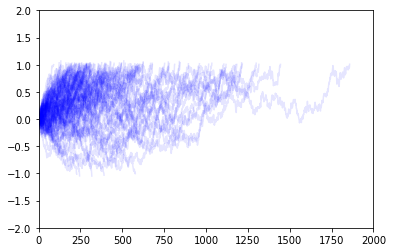

In [22]:
for i in range(100):
    out = cds.ddm_flexbound(v = 2.0, n_samples = 1, boundary_fun = bf.constant)
    plt.plot(out[2]['trajectory'][out[2]['trajectory'] > -999], color = 'blue', alpha = 0.1)
    plt.ylim([-2, 2])
    plt.xlim([0, 2000])

In [330]:
def save_plot_fun(plot = None):
    plot.savefig('testfile.png')
def return_plot_fun():
    fig = plt.figure(figsize = (8,8))
    plt.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100))
    plt.show()
    return fig
def return_plot():
    a = plt.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100))
    return a

In [2]:
angle_simulator(theta = [0, 1, 1, 0])

    return cds.ddm_flexbound(v = theta[0],
                            a = 2.0,
                            w = 0.6,
                            ndt = 0.9,
                            delta_t = 0.01, 
                            s = 1,
                            max_t = 20, 
                            n_samples = 20000,
                            boundary_fun = bf.angle,
                            boundary_multiplicative = False,
                            boundary_params = {'theta': 0.5})

IndentationError: unexpected indent (<ipython-input-2-327d8ab3fb1d>, line 3)

In [2]:
# v = np.random.uniform(low = -2, high = 2, size = 100)
# a = np.random.uniform(low = 0.5, high = 2.0, size = 100)
# w = np.random.uniform(low = 0.2, high = 0.8, size = 100)

# v = v[0]
# a = a[0]
# w = w[0]
out = cds.ddm(v = v, 
              a = a,
              w = w,
              ndt = 0.0, 
              delta_t = 0.001, 
              s = 1,  #np.sqrt(2),
              max_t = 20,
              n_samples = 20000)

NameError: name 'v' is not defined

In [91]:
from scipy.stats import gaussian_kde

In [92]:
my_kde = gaussian_kde(np.log(out[0][out[1] == -1]))
my_kde_2 = gaussian_kde(out[0][out[1] == -1])

In [97]:
logpdf_ =  - np.log(out[0][out[1] == -1]) + my_kde.logpdf(np.log(out[0][out[1] == -1])) 

In [ ]:
# np.sum( 1 / (out[0][out[1] == -1]) * my_kde.logpdf(np.log(out[0][out[1] == -1])))

In [102]:
logpdf_2 = my_kde_2.logpdf(out[0][out[1] == -1])

In [3]:
out_1 =  cds.ddm_flexbound(v = -.427,
                    a = 1.47,
                    w = 0.55,
                    ndt = 1.45,
                    delta_t = 0.01, 
                    s = 1,
                    max_t = 20, 
                    n_samples = 20000,
                    boundary_fun = bf.angle,
                    boundary_multiplicative = False,
                    boundary_params = {'theta': 0.87})

out_2 = cds.ddm_flexbound(v = -.29,
                    a = 1.42,
                    w = 0.56,
                    ndt = 1.14,
                    delta_t = 0.01, 
                    s = 1,
                    max_t = 20, 
                    n_samples = 20000,
                    boundary_fun = bf.angle,
                    boundary_multiplicative = False,
                    boundary_params = {'theta': 0.80})

In [7]:
out_1[2]

{'v': -0.4269999861717224,
 'a': 1.4700000286102295,
 'w': 0.550000011920929,
 'ndt': 1.4500000476837158,
 's': 1.0,
 'theta': 0.87,
 'delta_t': 0.009999999776482582,
 'max_t': 20.0,
 'n_samples': 20000,
 'simulator': 'ddm_flexbound',
 'boundary_fun_type': 'angle',
 'possible_choices': [-1, 1]}

(array([ 12.,  29., 100., 205., 274., 354., 470., 549., 626., 676., 709.,
        562., 747., 839., 814., 709., 774., 640., 535., 435., 299., 177.,
         56.,  14.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  16.,  91.,
        158., 332., 441., 517., 569., 631., 595., 634., 635., 545., 589.,
        448., 492., 434., 431., 429., 405., 326., 299., 196., 110.,  55.,
         13.]),
 array([-2.45999908, -2.4108991 , -2.36179912, -2.31269914, -2.26359916,
        -2.21449918, -2.16539919, -2.11629921, -2.06719923, -2.01809925,
        -1.96899927, -1.91989928, -1.8707993 , -1.82169932, -1.77259934,
        -1.72349936, -1.67439938, -1.62529939, -1.57619941, -1.52709943,
        -1.47799945, -1.42

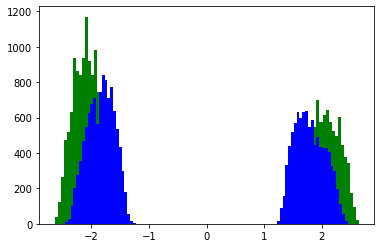

In [5]:
plt.hist(out_1[0] * out_1[1], color = 'green', bins = 100)
plt.hist(out_2[0] * out_2[1], color = 'blue', bins = 100)

(array([ 31.,   0.,   0.,  27., 171., 163., 115., 106.,  77.,  82.,  57.,
         45.,  46.,  42.,  31.,  15.,   0.,   0.,   0.,   0.,   0.,   6.,
          6.,   0.,   0.,   0.,   5.,   6.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.03      , 0.08139988, 0.13279976, 0.18419965, 0.23559952,
        0.2869994 , 0.33839926, 0.38979915, 0.44119903, 0.49259892,
        0.5439988 , 0.59539866, 0.64679855, 0.69819844, 0.7495983 ,
        0.8009982 , 0.85239804, 0.9037979 , 0.9551978 , 1.0065978 ,
        1.0579976 , 1.1093974 , 1.1607974 , 1.2121972 , 1.2635971 ,
        1.314997  , 1.3663969 , 1.4177967 , 1.4691966 , 1.5205965 ,
        1.5719963 , 1.6233963 , 1.6747961 , 1.726196  , 1.7775959 ,
        1.8289957 , 1.8803957 , 1.9317955 , 1.9831954 , 2.0345953 ,
        2.0859952 , 2.1373951 , 2.1887949 , 2.2401948 , 2.2915947 ,
        2.3429945 , 2.3943944 , 2.4457943 , 2.

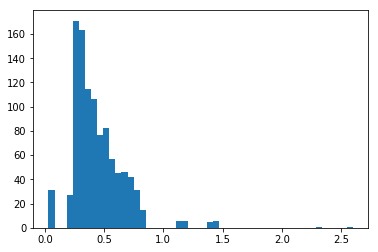

In [109]:
plt.hist(out_1[0][out[1] == -1][logpdf_ < logpdf_2], bins = 50)

In [101]:
logpdf_2

293.6286582297605

In [73]:
np.sum( my_kde.logpdf(np.log(out[0][out[1] == -1])) )

-1881.354850185424

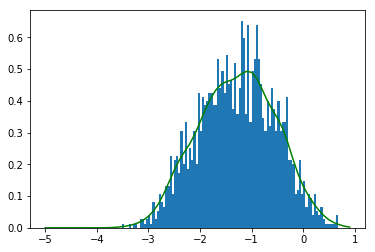

In [56]:
plt.hist(np.log(out[0][out[1] == -1]), bins = 100, density = True)
plt.plot(np.arange(-5, 1, 0.1), my_kde.pdf(np.arange(-5, 1, 0.1)), color = 'green')

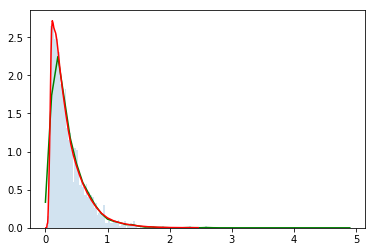

In [108]:
plt.hist(out[0][out[1] == -1], bins = 100, density = True, alpha = 0.2)
plt.plot(np.arange(0, 5, 0.1), my_kde_2.pdf(np.arange(0, 5, 0.1)), color = 'green')

y = np.exp(np.arange(-5, 1, 0.1))
plt.plot(y, (1 / y) * my_kde.pdf(np.arange(-5, 1, 0.1)), color = 'red')

In [36]:
np.sum(my_kde.logpdf(np.log(out[0][out[1] == -1])))

-1986.624764453648

In [84]:
my_kde_2.pdf(np.exp(np.arange(-5, 1, 0.1)))

array([3.90808553e-01, 3.97089856e-01, 4.04106654e-01, 4.11952769e-01,
       4.20735458e-01, 4.30577569e-01, 4.41620065e-01, 4.54024966e-01,
       4.67978764e-01, 4.83696378e-01, 5.01425674e-01, 5.21452582e-01,
       5.44106788e-01, 5.69767875e-01, 5.98871702e-01, 6.31916545e-01,
       6.69468253e-01, 7.12163133e-01, 7.60706600e-01, 8.15864607e-01,
       8.78443533e-01, 9.49252510e-01, 1.02904028e+00, 1.11839701e+00,
       1.21761082e+00, 1.32647134e+00, 1.44402000e+00, 1.56826415e+00,
       1.69590047e+00, 1.82213243e+00, 1.94070183e+00, 2.04425231e+00,
       2.12504694e+00, 2.17583481e+00, 2.19038228e+00, 2.16319545e+00,
       2.08878591e+00, 1.96242568e+00, 1.78482866e+00, 1.56964796e+00,
       1.34635701e+00, 1.15009615e+00, 9.99307863e-01, 8.79553000e-01,
       7.63070903e-01, 6.37010728e-01, 4.92989169e-01, 3.58475799e-01,
       2.47916535e-01, 1.75194190e-01, 1.57418010e-01, 1.14839299e-01,
       7.79238040e-02, 4.26931673e-02, 3.03559360e-02, 1.02157375e-02,
      

In [82]:
(1 / y) * my_kde.pdf(np.arange(-5, 1, 0.1))

array([7.74188898e-23, 2.87713686e-20, 7.23194152e-18, 1.22956220e-15,
       1.41411147e-13, 1.10032091e-11, 5.79395222e-10, 2.06568225e-08,
       4.99087910e-07, 8.18548129e-06, 9.14191291e-05, 6.99463065e-04,
       3.70844319e-03, 1.39168509e-02, 3.83434806e-02, 8.17749412e-02,
       1.42682813e-01, 2.11367611e-01, 2.74983309e-01, 3.41470107e-01,
       4.50599611e-01, 6.32168431e-01, 8.74432737e-01, 1.15011257e+00,
       1.43325166e+00, 1.69606970e+00, 1.91725254e+00, 2.08624244e+00,
       2.21226014e+00, 2.31751322e+00, 2.39645361e+00, 2.41696116e+00,
       2.37809837e+00, 2.32587801e+00, 2.29504625e+00, 2.26112268e+00,
       2.16678578e+00, 1.98658284e+00, 1.74825131e+00, 1.49946700e+00,
       1.27822172e+00, 1.10257967e+00, 9.66281381e-01, 8.47177680e-01,
       7.26337295e-01, 5.98461275e-01, 4.70029793e-01, 3.53748505e-01,
       2.60884516e-01, 1.94197620e-01, 1.46858689e-01, 1.09272134e-01,
       7.68614834e-02, 5.01654508e-02, 3.03503555e-02, 1.71006747e-02,
      

In [38]:
np.sum(my_kde_2.logpdf(out[0][out[1] == -1]))

250.72488101114968

In [39]:
from statsmodels.nonparametric.kde import KDEUnivariate

In [ ]:
KDEUnivariate()

In [2]:
repeats = 100
sample_sizes = [1024, 4096, 8192, 16384, 32768, 65536, 13172]
timings = []
v = np.random.uniform(low = -2, high = 2, size = 100)
a = np.random.uniform(low = 0.5, high = 2.0, size = 100)
w = np.random.uniform(low = 0.2, high = 0.8, size = 100)

for sample_size in sample_sizes:
    #kde_data = cds.ddm(n_samples = sample_size)
    #kde_data = kde_data[:2]
    #print('starting sample size: ', sample_size)
    
    now = time.time()
    for i in range(repeats):
#         print(v[i])
#         print(a[i])
#         print(w[i])
        out = cds.ddm(v = v[i], 
                      a = a[i],
                      w = w[i],
                      ndt = 0.0, 
                      delta_t = 0.001, 
                      s = 1,  #np.sqrt(2),
                      max_t = 20,
                      n_samples = 100000)
        #print('done simulating')

        #my_kde = kde.logkde(out)
        #evals = my_kde.kde_eval(data = kde_data)
        #print('done with kde eval')

        if i % 10 == 0:
            print(i)
    timings.append((time.time() - now) / repeats)

print((time.time() - now) / repeats)

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0.7677662205696106


In [12]:
repeats = 1
now = time.time()

for i in range(repeats):
    out2 = cds.ddm_flexbound_pre(v = 0.0, 
                                 a = 3.0,
                                 w = 0.5,
                                 ndt = 0.0, 
                                 delta_t = 0.001, 
                                 s = 1,  #np.sqrt(2),
                                 max_t = 20,
                                 n_samples = 10000,
                                 boundary_fun = bf.constant,
                                 boundary_multiplicative = False, 
                                 boundary_params = {'theta': 0.0})
                                 #boundary_params = {"theta": 0.01})
    if i % 10 == 0:
        print(i)

print((time.time() - now) / repeats)

0
2.4775609970092773


(array([3.000e+00, 1.000e+00, 5.000e+00, 2.000e+00, 2.000e+00, 8.000e+00,
        1.600e+01, 3.100e+01, 3.700e+01, 3.900e+01, 7.100e+01, 8.800e+01,
        1.330e+02, 1.400e+02, 2.280e+02, 2.470e+02, 2.930e+02, 3.610e+02,
        4.280e+02, 5.090e+02, 5.440e+02, 6.580e+02, 7.690e+02, 9.190e+02,
        1.120e+03, 1.338e+03, 1.532e+03, 1.923e+03, 2.020e+03, 1.354e+03,
        6.900e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 9.400e+01,
        3.120e+02, 4.560e+02, 4.580e+02, 4.670e+02, 5.050e+02, 3.830e+02,
        3.720e+02, 3.770e+02, 3.170e+0

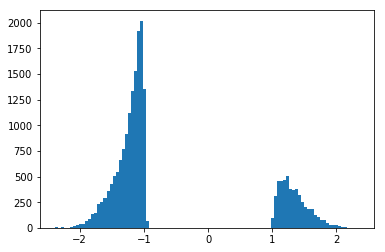

In [19]:
plt.hist(out[0]*out[1], bins = 100)

In [20]:
repeats = 10
now = time.time()

for i in range(repeats):
    out = cds.ddm_flexbound(v = -0.5, 
                            a = 0.7,
                            w = 0.4,
                            ndt = 0.93, 
                            delta_t = 0.001, 
                            s = 1,  #np.sqrt(2),
                            max_t = 20,
                            n_samples = 20000,
                            boundary_fun = bf.angle,
                            boundary_multiplicative = False, 
                            boundary_params = {'theta': 0.3})
                            #boundary_params = {"theta": 0.01})
    if i % 10 == 0:
        print(i)
  
print((time.time() - now) / repeats)

0
0.20710887908935546


(array([4.000e+00, 1.000e+00, 2.000e+00, 6.000e+00, 8.000e+00, 1.100e+01,
        2.200e+01, 3.000e+01, 3.800e+01, 5.000e+01, 5.900e+01, 1.150e+02,
        1.260e+02, 1.480e+02, 1.820e+02, 2.370e+02, 2.770e+02, 3.620e+02,
        4.440e+02, 5.730e+02, 6.280e+02, 7.520e+02, 8.710e+02, 1.039e+03,
        1.280e+03, 1.492e+03, 1.700e+03, 2.017e+03, 1.771e+03, 4.610e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.800e+01, 3.020e+02,
        4.480e+02, 5.170e+02, 5.120e+02, 4.760e+02, 4.680e+02, 4.060e+02,
        3.670e+02, 3.270e+02, 2.700e+0

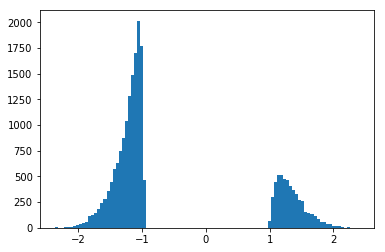

In [21]:
plt.hist(out[0]*out[1], bins = 100)

In [11]:
# DDM
now = time.time()
repeats = 1
my_means = np.zeros(repeats)

v_vec = np.random.uniform(low = -3, high = 3, size = 5000)
a_vec = np.random.uniform(low = 0.5, high = 2.5, size = 5000)
w_vec = np.random.uniform(low = 0.2, high = 0.8, size = 5000)
dw_vec = np.random.uniform(low = 0.05, high = 0.1, size = 5000)
sdv_vec = np.random.uniform(low = -2.5, high = -2.5, size = 5000)
dndt = 0.1
ndt = 1



for i in range(repeats):
    out = cds.full_ddm(v = -0.12, 
                       a = 2.0,
                       w = 0.99,
                       ndt = 0.93, 
                       dw = 0,
                       sdv = 0,
                       dndt = 0,
                       delta_t = 0.001, 
                       s = 1,  #np.sqrt(2),
                       max_t = 20,
                       n_samples = 20000,
                       boundary_fun = bf.constant,
                       boundary_multiplicative = True, 
                       boundary_params = {})
                       #boundary_params = {"theta": 0.01})
    if i % 100 == 0:
        print(i)
    
    my_means[i] = np.mean(out[0][out[1] == 1])
    
print(time.time() - now)

0
0.1838829517364502


In [7]:
np.random.uniform(low= -1, high = 2, size = 1000)

array([ 9.68210300e-02, -2.50630771e-02,  6.32613612e-01, -5.41730074e-01,
        4.92690684e-01, -5.27362446e-02, -9.45719158e-01, -6.00292601e-01,
        1.03545782e+00, -4.51041286e-01, -5.92502382e-01, -7.73231594e-01,
        4.22952152e-01, -9.03050808e-01,  9.13081343e-01,  7.73354314e-01,
        1.95701594e-02,  1.45641079e+00,  1.12542351e+00,  1.82689034e+00,
        1.88653215e+00, -2.35638584e-01,  3.07012865e-01,  7.25416684e-01,
        1.54732993e+00,  4.17456462e-03, -8.27312168e-01,  1.39098540e+00,
        6.45691376e-01,  1.76191991e+00, -5.35368453e-01,  8.49760735e-03,
        1.04095366e+00, -7.38055654e-01, -2.93444344e-01,  4.86806733e-01,
       -9.98708438e-01,  1.60121484e-01,  1.49868414e+00, -7.70565600e-01,
        1.99795810e+00, -6.85388104e-01,  1.13876486e+00,  6.79229751e-01,
       -7.83968061e-01, -7.96254508e-01,  1.30805971e+00, -4.58494793e-01,
        3.09233865e-01,  4.19219572e-01,  4.99748299e-01,  8.78974332e-01,
       -8.84283350e-01, -

(array([1.65165165e-04, 0.00000000e+00, 4.95495495e-04, 0.00000000e+00,
        8.25825826e-04, 0.00000000e+00, 6.60660661e-04, 3.30330330e-04,
        3.30330330e-04, 4.95495495e-04, 4.95495495e-04, 3.30330330e-04,
        8.25825826e-04, 9.90990991e-04, 9.90990991e-04, 3.30330330e-04,
        9.90990991e-04, 1.32132132e-03, 8.25825826e-04, 8.25825826e-04,
        9.90990991e-04, 1.48648649e-03, 9.90990991e-04, 1.15615616e-03,
        1.98198198e-03, 1.98198198e-03, 2.47747748e-03, 2.97297297e-03,
        2.80780781e-03, 2.80780781e-03, 4.12912913e-03, 2.97297297e-03,
        3.13813814e-03, 2.64264264e-03, 5.45045045e-03, 2.80780781e-03,
        3.30330330e-03, 4.78978979e-03, 6.44144144e-03, 3.79879880e-03,
        2.97297297e-03, 2.31231231e-03, 6.60660661e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.84843844e+00, 1.91096096e-01, 5.05405405e-02, 2.923423

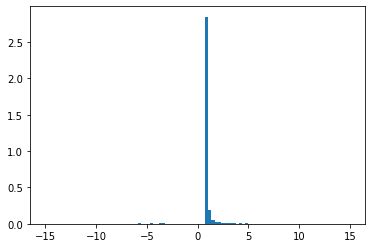

In [12]:
plt.hist(out[0] * out[1], bins = np.linspace(-15, 15, 100), density = True)

In [6]:
out = cds.ddm_sdv(v = -3,
                  a = 2.5, 
                  w = 0.3,
                  ndt = 1,
                  sdv = 0,
                  s = 1,
                  boundary_fun = bf.constant, 
                  delta_t = 0.001,
                  n_samples = 100000)

In [4]:
out[0] * out[1]

array([[-2.64002061],
       [-1.83699274],
       [-2.17499876],
       ...,
       [-2.72102451],
       [-2.14299726],
       [-3.4240067 ]])

In [2]:
my_bins = np.arange(- 512, 513) * 20 / 1024

In [7]:
analy_out = batch_fptd(t = my_bins.copy(),
                       v = 3,
                       a = 5,
                       w = 0.7,
                       ndt = 1,
                       sdv = 0,
                       eps = 1e-50)

In [11]:
(analy_out <= 1e-48).nonzero()

(array([500, 501, 502, 512, 513, 514, 515, 527, 528, 529, 530, 531, 532,
        533, 534, 535, 536, 537, 538, 539, 540, 541, 564, 565, 566, 567,
        568, 569, 570, 571]),)

In [6]:
analy_out[500:550]

array([1.00000000e-48, 1.00000000e-48, 1.00000000e-48, 5.50616556e-01,
       3.22339017e-01, 1.53733429e-01, 5.36728989e-02, 1.12941078e-02,
       9.67429341e-04, 1.33839486e-05, 1.81829580e-09, 1.74461203e-21,
       1.00000000e-48, 1.00000000e-48, 1.00000000e-48, 1.00000000e-48,
       1.10747000e-37, 4.68310627e-31, 1.13088050e-26, 1.43733582e-23,
       2.91372804e-21, 1.74238274e-19, 5.35018169e-07, 3.96000533e-07,
       2.92625196e-07, 2.15883993e-07, 3.69686945e-09, 1.00000000e-48,
       1.00000000e-48, 1.00000000e-48, 1.00000000e-48, 1.00000000e-48,
       1.00000000e-48, 1.00000000e-48, 1.00000000e-48, 1.00000000e-48,
       1.00000000e-48, 1.00000000e-48, 1.00000000e-48, 1.00000000e-48,
       1.00000000e-48, 1.00000000e-48, 5.44773932e-08, 4.58746556e-08,
       3.86317258e-08, 3.25389056e-08, 2.74179696e-08, 2.31175490e-08,
       1.95091806e-08, 1.64839255e-08])

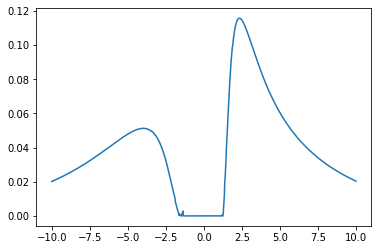

In [37]:
plt.plot(my_bins, analy_out)

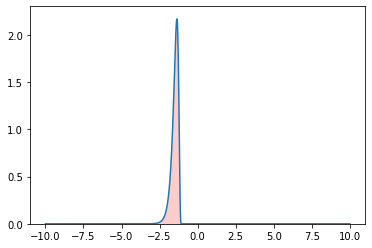

In [8]:
plt.hist(out[0] * out[1], 
         bins = np.arange(-512, 513) * 20/1024 , 
         alpha = 0.2, 
         color = 'red', 
         density = 1)

plt.plot(my_bins, analy_out)

In [9]:
cumsum = 0
for i in range(1, analy_out.shape[0], 1):
    cumsum += ((analy_out[i - 1] + analy_out[i]) / 2) * (my_bins[1] - my_bins[0])

In [10]:
cumsum

0.999999999705487

In [61]:
np.exp(25)

72004899337.38588

In [61]:
analy_out.shape

(1025,)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  42., 213., 411., 644., 701., 840.,
        836., 840., 742., 779., 755., 679., 620., 597., 557., 549., 540.,
        482., 412., 448., 388., 341., 351., 268., 294., 260., 267., 232.,
        214., 230., 181., 176., 183., 169., 158., 143., 129., 116., 135.,
        139., 124.,  93., 104.,  82.,  93.,  73.,  87.,  63.,  63.,  62.,
         61.,  57.,  49.,  53.,  43.,  44.,  35.,  31.,  26.,  21.,  23.,
         31.,  32.,  19.,  19.,  21.,  15.,  15.,  11.,  20.,  21.,  12.,
         18.,   5.,  11.,   8.,   6.,   7.,  10.,   7.,   5.,   6.,   1.,
          2.,   7.,   5.,   5.,   7.,   2.,   4.,   3.,   3.,   4.,   4.,
          2.,   3.,   6.,   2.,   1.,   4.,   1.,   0.,   3.,   2.,   4.,
          2.,   2.,   2.,   0.,   1.,   1.,   3.,   0.,   1.,   1.,   0.,
          0.,   1.,   1.,   0.,   0., 

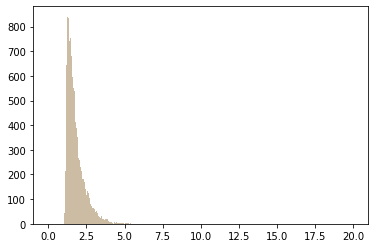

In [16]:
plt.hist(out[0][out[1][:, 0] == -1, 0], bins = np.arange(512) * 20/512 , alpha = 0.2, color = 'red')
plt.hist(out[0][out[1][:, 0] == 1, 0], bins = np.arange(512) * 20/512 , alpha = 0.2, color = 'green')

2.0
1.01


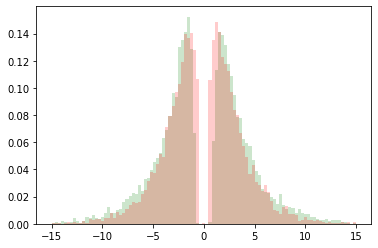

In [23]:
# DDM  
repeats = 1
colors = ['green', 'red']
my_means = np.zeros(repeats)
cnt = 0
for i in np.linspace(2, 1.01, 2):
    out = cds.levy_flexbound(v = 0, 
                             a = 2.5,
                             w = 0.5,
                             alpha_diff = i,
                             ndt = 0.5,
                             delta_t = 0.001, 
                             max_t = 20,
                             n_samples = 10000,
                             boundary_fun = bf.constant,
                             boundary_multiplicative = True, 
                             boundary_params = {})
                            #boundary_params = {"theta": 0.01})
    plt.hist(out[0] * out[1], bins = np.linspace(-15, 15, 100), density = True, alpha = 0.2, color = colors[cnt])
    print(i)
    cnt += 1
    
    #my_means[i] = np.mean(out[0][out[1] == 1])
plt.show()

In [12]:
def bin_simulator_output(out = [0, 0],
                         bin_dt = 0.04,
                         n_bins = 0,
                         eps_correction = 1e-7, # min p for a bin
                         params = ['v', 'a', 'w', 'ndt']
                        ): # ['v', 'a', 'w', 'ndt', 'angle']

    # Generate bins
    if n_bins == 0:
        n_bins = int(out[2]['max_t'] / bin_dt)
        bins = np.linspace(0, out[2]['max_t'], n_bins)
    else:    
        bins = np.linspace(0, out[2]['max_t'], n_bins)
        bins = np.append(bins, [100])
        print(bins)
    counts = []
    cnt = 0
    counts = np.zeros( (n_bins, len(out[2]['possible_choices']) ) )
    counts_size = counts.shape[0] * counts.shape[1]
    
    for choice in out[2]['possible_choices']:
        counts[:, cnt] = np.histogram(out[0][out[1] == choice], bins = bins)[0] / out[2]['n_samples']
        cnt += 1
    
    # Apply correction for empty bins
    n_small = 0
    n_big = 0
    n_small = np.sum(counts < eps_correction)
    n_big = counts_size - n_small 
    
    if eps_correction > 0:
        counts[counts <= eps_correction] = eps_correction
        counts[counts > eps_correction] -= (eps_correction * (n_small / n_big))

    return ([out[2][param] for param in params], # features
            counts, # labels
            {'max_t': out[2]['max_t'], 
             'bin_dt': bin_dt, 
             'n_samples': out[2]['n_samples']} # meta data
           )


def bin_simulator_output(self, 
                         out = [0, 0],
                         bin_dt = 0.04,
                             nbins = 0): # ['v', 'a', 'w', 'ndt', 'angle']
        
        # Generate bins
        if nbins == 0:
            nbins = int(out[2]['max_t'] / bin_dt)
            bins = np.zeros(nbins + 1)
            bins[:nbins] = np.linspace(0, out[2]['max_t'], nbins)
            bins[nbins] = np.inf
        else:  
            bins = np.zeros(nbins + 1)
            bins[:nbins] = np.linspace(0, out[2]['max_t'], nbins)
            bins[nbins] = np.inf

        cnt = 0
        counts = np.zeros( (nbins, len(out[2]['possible_choices']) ) )

        for choice in out[2]['possible_choices']:
            counts[:, cnt] = np.histogram(out[0][out[1] == choice], bins = bins)[0] / out[2]['n_samples']
            cnt += 1
        return counts

In [ ]:
#%%timeit -n 1 -r 5
a, b = bin_simulator_output(out = out)

In [184]:
%%timeit -n 5 -r 1
out = cds.ornstein_uhlenbeck(v = 0.0,
                             a = 1.5,
                             w = 0.5,
                             g = 0,
                             ndt = 0.92,
                             delta_t = 0.001,
                             boundary_fun = bf.constant,
                             n_samples = 100000)

36.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [ ]:
binned_sims = bin_simulator_output(out = out,
                                   n_bins = 256,
                                   eps_correction = 1e-7,
                                   params = ['v', 'a', 'w', 'g', 'ndt'])

In [181]:
%%timeit -n 5 -r 1
out = cds.ddm_flexbound_seq2(v_h = 0,
                             v_l_1 = 0,
                             v_l_2 = 0,
                             a = 1.5,
                             w_h = 0.5,
                             w_l_1 = 0.5,
                             w_l_2 = 0.5,
                             ndt = 0.5,
                             s = 1,
                             delta_t = 0.001,
                             max_t = 20,
                             n_samples = 100000,
                             print_info = True,
                             boundary_fun = bf.constant, # function of t (and potentially other parameters) that takes in (t, *args)
                             boundary_multiplicative = True,
                             boundary_params = {})

1min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [180]:
%%timeit -n 5 -r 1
out = cds.ddm_flexbound_par2(v_h = 0,
                             v_l_1 = 0,
                             v_l_2 = 0,
                             a = 1.5,
                             w_h = 0.5,
                             w_l_1 = 0.5,
                             w_l_2 = 0.5,
                             ndt = 0.5,
                             s = 1,
                             delta_t = 0.001,
                             max_t = 20,
                             n_samples = 100000,
                             print_info = True,
                             boundary_fun = bf.constant, # function of t (and potentially other parameters) that takes in (t, *args)
                             boundary_multiplicative = True,
                             boundary_params = {})

1min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [178]:
%%timeit -n 5 -r 1 
out = cds.ddm_flexbound_mic2(v_h = 0.0,
                             v_l_1 = 0.0,
                             v_l_2 = 0.0,
                             a = 1.5,
                             w_h = 0.5,
                             w_l_1 = 0.5,
                             w_l_2 = 0.5,
                             d = 1.0, 
                             ndt = 0.5,
                             s = 1,
                             delta_t = 0.001,
                             max_t = 20,
                             n_samples = 100000,
                             print_info = True,
                             boundary_fun = bf.constant, # function of t (and potentially other parameters) that takes in (t, *args)
                             boundary_multiplicative = True,
                             boundary_params = {})

1min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  2.,  3.,  1.,  1.,  4.,  6.,  6.,  4., 10., 10.,
         3., 10., 13.,  6., 11., 19., 19., 23., 20., 33., 22., 27., 17.,
        33., 21., 31., 33., 17., 27., 21., 38., 24., 26., 35., 24., 19.,
        24., 44., 33., 30., 39., 34., 52., 34., 35., 38., 43., 37., 34.,
        36., 32., 37., 43., 28., 58., 30., 27., 46., 40., 46., 45., 36.,
        44., 39., 41., 31., 51., 29., 44., 40., 36., 38., 37., 43., 37.,
        34., 29., 25., 50., 44., 49., 41., 43., 42., 29., 41., 23., 36.,
        27., 39., 35., 43., 36., 37., 37., 28., 39., 33., 25., 49., 35.,
        52., 26., 31., 34., 44., 38., 49., 38., 30., 29., 34., 32., 26.,
        26., 28., 33., 29., 35., 30., 32., 34., 40., 26., 32., 26., 29.,
        38., 42., 32., 28., 30., 34., 26., 33., 28., 24., 40., 30., 24.,
        29., 32., 28., 36., 34., 23., 30., 30., 26.

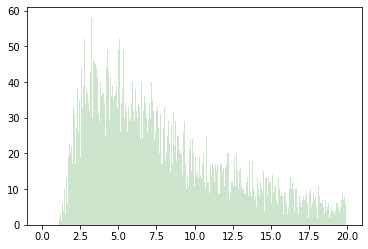

In [217]:
plt.hist(out[0][out[1][:, 0] == 0, 0], bins = np.arange(512) * 20/512 , alpha = 0.2, color = 'red')
plt.hist(out[0][out[1][:, 0] == 1, 0], bins = np.arange(512) * 20/512 , alpha = 0.2, color = 'green')
#plt.hist(out[0][out[1][:, 0] == 2, 0], bins = np.arange(512) * 20/512 , alpha = 0.2, color = 'red')
#plt.hist(out[0][out[1][:, 0] == 3, 0], bins = np.arange(512) * 20/512 , alpha = 0.2, color = 'green')

In [185]:
import pickle
import os


In [188]:
os.listdir('/media/data_cifs/afengler/data/kde/ddm_seq2/training_data_binned_1_nbins_512_n_100000')

['ddm_seq2_nchoices_2_train_data_binned_1_nbins_512_n_100000_999.pickle']

In [211]:
tt = pickle.load(open('/media/data_cifs/afengler/data/kde/ddm_mic2/training_data_binned_1_nbins_512_n_100000/ddm_mic2_nchoices_2_train_data_binned_1_nbins_512_n_100000_999.pickle', 'rb'))

In [195]:
tt[1][0][:,0]

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.000e-05, 2.300e-04,
       7.500e-04, 1.630e-03, 2.620e-03, 3.470e-03, 5.330e-03, 5.970e-03,
       7.820e-03, 8.140e-03, 9.420e-03, 9.680e-03, 1.008e-02, 1.038e-02,
       1.083e-02, 1.139e-02, 1.050e-02, 1.050e-02, 1.000e-02, 1.021e-02,
       9.690e-03, 9.210e-03, 8.560e-03, 8.420e-03, 7.900e-03, 6.960e-03,
       6.720e-03, 6.960e-03, 6.690e-03, 6.050e-03, 5.490e-03, 5.400e-03,
       5.210e-03, 4.600e-03, 4.820e-03, 4.620e-03, 4.070e-03, 3.630e-03,
       3.420e-03, 2.790e-03, 3.010e-03, 3.260e-03, 2.740e-03, 2.280e-03,
       2.180e-03, 2.040e-03, 1.880e-03, 1.860e-03, 1.610e-03, 1.450e-03,
       1.450e-03, 1.540e-03, 1.210e-03, 1.060e-03, 1.100e-03, 1.100e-03,
       1.040e-03, 1.060e-03, 7.500e-04, 8.500e-04, 

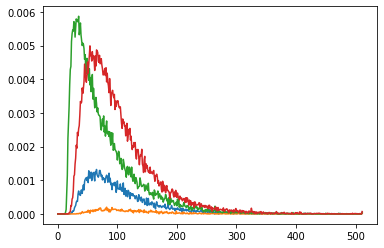

In [215]:
plt.plot(tt[1][2, :,0])
plt.plot(tt[1][2, :,1])
plt.plot(tt[1][2, :,2])
plt.plot(tt[1][2, :,3])

In [145]:
print(np.mean(out[0][out[1][:, 0] == 0, 0]))
print(np.mean(out[0][out[1][:, 0] == 1, 0]))
#print(np.mean(out[0][out[1][:, 0] == 2, 0]))
#print(np.mean(out[0][out[1][:, 0] == 3, 0]))

1.9529729
1.9603328


In [146]:
print(np.shape(out[0][out[1][:, 0] == 0, 0]))
print(np.shape(out[0][out[1][:, 0] == 1, 0]))
#print(np.shape(out[0][out[1][:, 0] == 2, 0]))
#print(np.shape(out[0][out[1][:, 0] == 3, 0]))

(24981,)
(24776,)


In [143]:
np.sort(out[0][out[1][:,0] == 1, 0])

array([ 0.6530001,  0.6530001,  0.6530001, ...,  9.054827 ,  9.446985 ,
       13.031434 ], dtype=float32)

(array([5.660e+02, 2.480e+03, 3.954e+03, 4.277e+03, 4.152e+03, 3.769e+03,
        3.262e+03, 2.780e+03, 2.322e+03, 1.880e+03, 1.455e+03, 1.157e+03,
        9.380e+02, 7.480e+02, 5.870e+02, 4.720e+02, 3.540e+02, 2.990e+02,
        2.170e+02, 1.910e+02, 1.350e+02, 1.160e+02, 7.500e+01, 8.600e+01,
        6.700e+01, 4.800e+01, 2.800e+01, 4.000e+01, 2.600e+01, 1.200e+01,
        1.100e+01, 1.000e+01, 7.000e+00, 8.000e+00, 1.000e+01, 4.000e+00,
        5.000e+00, 5.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.7490003,  1.0663557,  1.3837112,  1.7010666,  2.0184221,
         2.3357775,  2.653133 ,  2.9704883,  3.2878437,  3.605199 ,
         3.9225545,  4.23991  ,  4.5572653,  4.874621 ,  5.191976 ,
         5.5093317,  5.8266873,  6.1440425,  6.461398 ,  6.7787533,
         7.096109 ,  7.413464 ,  7.7308197,  8.048175 ,  8.365531 ,
         8.682886 ,  9.000241 ,  9.3

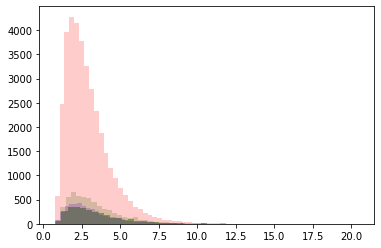

In [121]:
plt.hist(out[0][out[1][:, 0] == 0, 0], bins = 50, alpha = 0.5, color = 'green')
plt.hist(out[0][out[1][:, 0] == 1, 0], bins = 50, alpha = 0.2, color = 'green')
plt.hist(out[0][out[1][:, 0] == 2, 0], bins = 50, alpha = 0.2, color = 'blue')
plt.hist(out[0][out[1][:, 0] == 3, 0], bins = 50, alpha = 0.2, color = 'red')

In [122]:
print(np.max(out[0][out[1][:, 0] == 0, 0]))
print(np.max(out[0][out[1][:, 0] == 1, 0]))
print(np.max(out[0][out[1][:, 0] == 2, 0]))
print(np.max(out[0][out[1][:, 0] == 3, 0]))

20.500637
17.52927
14.810153
16.616772


In [ ]:
binned_sims = bin_simulator_output(out = out,
                                   n_bins = 256,
                                   eps_correction = 1e-7,
                                   params = ['v', 'a', 'w', 'g', 'ndt'])

In [ ]:
plt.plot(binned_sims[1][:, 1])
plt.plot(binned_sims[1][:, 0])

In [ ]:
binned_sims[1][255, 1]

In [ ]:
files_ = os.listdir('/media/data_cifs/afengler/data/kde/ddm/base_simulations_20000')

In [ ]:
labels = np.zeros((250000, 500, 2))
features = np.zeros((250000, 3))

cnt = 0
i = 0
file_dim = 100
for file_ in files_[:1000]:
    if file_[:8] == 'ddm_flex':
        out = pickle.load(open('/media/data_cifs/afengler/data/kde/ddm/base_simulations_20000/' + file_, 'rb'))
        features[cnt], labels[cnt] = bin_simulator_output(out = out)
        if cnt % file_dim == 0:
            print(cnt)
            pickle.dump((labels[(i * file_dim):((i + 1) * file_dim)], features[(i * file_dim):((i + 1) * file_dim)]), open('/media/data_cifs/afengler/data/kde/ddm/base_simulations_20000_binned/dataset_' + str(i), 'wb'))
            i += 1
        cnt += 1


In [ ]:
# FULL DDM  
repeats = 50
my_means = np.zeros(repeats)
for i in range(repeats):
    out = cds.full_ddm(v = 0, 
                       a = 0.96,
                       w = 0.5,
                       ndt = 0.5,
                       dw = 0.0,
                       sdv = 0.0,
                       dndt = 0.5,
                       delta_t = 0.01, 
                       max_t = 20,
                       n_samples = 10000,
                       boundary_fun = bf.constant,
                       boundary_multiplicative = True, 
                       boundary_params = {})
    print(i)
    
    my_means[i] = np.mean(out[0][out[1] == 1])

In [ ]:
plt.hist(out[0] * out[1], bins = 50)

In [ ]:
int(50 / out[2]['delta_t'] + 1)

In [209]:
# LCA 
repeats = 1
my_means = np.zeros(repeats)
for i in range(repeats):
    out = cds.lca(v = np.array([0, 0.5, 1], dtype = np.float32), 
                  a = 2, 
                  w = np.array([0.5, 0.6, 0.7], dtype = np.float32), 
                  ndt = np.array([1.0], dtype = np.float32),
                  g = 0,
                  b = 1.0,
                  delta_t = 0.01, 
                  max_t = 20,
                  n_samples = 10000,
                  boundary_fun = bf.constant,
                  boundary_multiplicative = True, 
                  boundary_params = {})
    print(i)
    my_means[i] = np.mean(out[0][out[1] == 1])

0


In [202]:
out[2]

{'v_0': 0.0,
 'v_1': 0.5,
 'v_2': 1.0,
 'a': 2.0,
 'w_0': 0.5,
 'w_1': 0.6,
 'w_2': 0.7,
 'g': -1.0,
 'b': 1.0,
 'ndt': 1.0,
 's': 1.0,
 'delta_t': 0.009999999776482582,
 'max_t': 40.0,
 'n_samples': 10000,
 'simulator': 'lca',
 'boundary_fun_type': 'constant',
 'possible_choices': [0, 1, 2]}

In [211]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
nbins = 100
cnt = 0
for c, z in zip(['r', 'g', 'b'], [0, 1, 2]):
    #ys = np.random.normal(loc=10, scale=10, size=2000)

    hist, bins = np.histogram(out[0][out[1] == cnt], bins = nbins, density = True)
    #xs = (bins[:-1] + bins[1:]) / 2
    #ax.bar(xs, hist, zs = z, zdir = 'y', color = c, ec = c, alpha=0.5)
    ax.hist(out[0][out[1] == cnt], bins = 50, histtype = 'step' ,zs = z)
    cnt += 1
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

AttributeError: Unknown property zs

AttributeError: 'Polygon' object has no attribute 'do_3d_projection'

<Figure size 432x288 with 1 Axes>

In [ ]:
out[1][out[1] == 0] = -1
plt.hist(out[0] * out[1], bins = 50)

In [ ]:
# LCA 
repeats = 10
my_means = np.zeros(repeats)
for i in range(repeats):
    out = cds.ddm_flexbound(v = 0.0, 
                            a = 1.5, 
                            w = 0.5, 
                            ndt = 0.1,
                            delta_t = 0.01, 
                            max_t = 40,
                            n_samples = 10000,
                            boundary_fun = bf.constant,
                            boundary_multiplicative = True, 
                            boundary_params = {})
    print(i)
    my_means[i] = np.mean(out[0][out[1] == 1])

In [ ]:
def foo(name, *args, **kwargs):
    print ("args: ", args)
    print ("Type of args: ", type(args))
    if len(args)>2:
        args = args[0], args[1]     #- Created Same name variable.
    print ("Temp args:", args)

In [ ]:
my_keys = []
for key in test_dat.keys():
    if key[0] == 'v':
        my_keys.append(key)
np.array(test_dat.loc[1, ['v_0', 'v_1']])

In [ ]:
my_dat = mdlba.make_data_rt_choice(target_folder = my_target_folder)

In [ ]:
np.max(my_dat['log_likelihood'])

In [ ]:
data = np.concatenate([out[0], out[1]], axis = 1)

In [ ]:
###
cds.race_model(boundary_fun = bf.constant,
              n_samples = 100000)

In [ ]:
np.quantile(np.random.uniform(size = (10000,4)), q = [0.05, 0.10, 0.9, 0.95], axis = 0)

In [ ]:
tuple(map(tuple, a))

In [ ]:
tuple(np.apply_along_axis(my_func, 0, a, key_vec))

In [ ]:
dict(zip(a[0,:], ['a' ,'b', 'c']))

In [ ]:
def my_func(x = 0, key_vec = ['a' ,'b', 'c']):
    return dict(zip(key_vec, x))

In [ ]:
my_func_init = my_func(key_vec = ['d', 'e', 'f'])

In [ ]:
test = yaml.load(open('config_files/config_data_generator.yaml'))

In [22]:
from multiprocessing import Pool

def myfunc(a):
    return a ** 2
pbar = tqdm(total = 100)
def update():
    pbar.update

a = tuple()
for i in range(pbar.total):
    a += ((1, ), )
    
pool = Pool(4)
pool.starmap(myfunc, a, callback = update)
pool.close()
pool.join()






  0%|          | 0/100 [00:00<?, ?it/s]

TypeError: starmap() got an unexpected keyword argument 'callback'

In [ ]:
def my_fun(*args):
    print(args)

In [ ]:
help(dg.make_dataset_r_dgp)

In [ ]:
def zip_dict(x = [], 
             key_vec = ['a', 'b', 'c']):
    return dict(zip(key_vec, x))

In [ ]:
my_dg = dg.data_generator(file_id = 'TEST')

In [ ]:
out = my_dg.make_dataset_perturbation_experiment(save = False)

In [ ]:
out = my_dg.make_dataset_uniform(save = False)

In [ ]:
my_dg.param_grid_perturbation_experiment()

In [ ]:
param_grid = my_dg.param_grid_uniform()

In [ ]:
%%timeit -n 1 -r 1
tt = my_dg.generate_data_grid_parallel(param_grid = param_grid)

In [22]:
3**3

27

In [ ]:
a = np.random.choice(10, size = (1000,1))

In [25]:
for i in zip([1,2,3], [1, 2, 3], [1]):
    print( i )

(1, 1, 1)


In [13]:
from scipy.stats import truncnorm

In [19]:
x = truncnorm.rvs(-1, 3, size = 10000)

(array([1365., 1729., 1850., 1708., 1387.,  969.,  552.,  276.,  122.,
          42.]),
 array([ 9.50002079,  9.69642827,  9.89283574, 10.08924321, 10.28565068,
        10.48205815, 10.67846562, 10.87487309, 11.07128056, 11.26768803,
        11.4640955 ]),
 <a list of 10 Patch objects>)

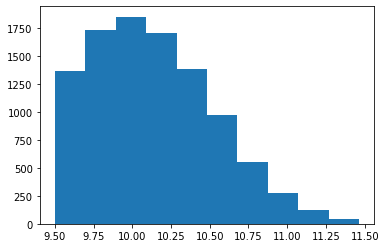

In [22]:
plt.hist(10 + x * 0.5)

In [22]:
x = pickle.load(open('/users/afengler/OneDrive/project_nn_likelihoods/eLIFE_exps/summaries/IS_summary_weibull_cdf_N_1024.pickle', 'rb' ))

In [147]:
x = pickle.load(open('/Users/afengler/OneDrive/project_nn_likelihoods/data/kde/weibull_cdf2/method_comparison/dnnregressor_weibull_cdf2_06_11_20_03_30_02/summary_post_samp_data_param_recov_unif_reps_1_n_1024_init_mle_1.pickle', 'rb'))

In [162]:
x = pickle.load(open('/Users/afengler/OneDrive/project_sbi_experiments/posterior_samples/collapsed_angle_bindim_64_abcmethod_SNPE_nsimruns_100000_nsamplesl_1000_nsamplesh_50000_nobs_1000_bd743603c0504bb786265fc0fa231748.pickle', 'rb'))

In [191]:
files_[0][:-40] + '.pickle'

'collapsed_full_ddm_bindim_64_abcmethod_SNPE_nsimruns_100000_nsamplesl_100_nsamplesh_10000_nobs_2000.pickle'

In [195]:
x = pickle.load(open('/Users/afengler/OneDrive/project_sbi_experiments/posterior_samples/collapsed_angle_bindim_64_abcmethod_SNPE_nsimruns_100000_nsamplesl_1000_nsamplesh_50000_nobs_1000.pickle', 'rb'))

In [196]:
x['gt'].shape

(1000, 5)

In [193]:
dir_ = '/Users/afengler/OneDrive/project_sbi_experiments/posterior_samples/'
files_ = os.listdir('/Users/afengler/OneDrive/project_sbi_experiments/posterior_samples/')
for file_ in files_:
    print(file_)
    x = pickle.load(open(dir_ + file_, 'rb'))
    x['gt'] = np.squeeze(x['gt'])
    x['posterior_samples'] = np.squeeze(x['posterior_samples'])
    x['posterior_samples_log_p'] = np.squeeze(x['posterior_samples_log_p'])
    x['data'] = np.squeeze(x['data'])
    x['maps'] = np.squeeze(x['maps'])
    x['means'] = np.squeeze(x['means'])
    x['timings'] = np.squeeze(x['timings'])
    pickle.dump(x, open(dir_ + file_[:-40] + '.pickle','wb'))

collapsed_full_ddm_bindim_64_abcmethod_SNPE_nsimruns_100000_nsamplesl_100_nsamplesh_10000_nobs_2000_73fc2cea64a44dcf8c674806854ff1cc.pickle
collapsed_levy_bindim_64_abcmethod_SNPE_nsimruns_100000_nsamplesl_1000_nsamplesh_50000_nobs_2000_cb8af390da65465fb5dc1361ea48e09e.pickle
collapsed_ornstein_bindim_64_abcmethod_SNPE_nsimruns_100000_nsamplesl_1000_nsamplesh_50000_nobs_1000_6c40a041eb3743e29255d87917a8e292.pickle
collapsed_levy_bindim_64_abcmethod_SNPE_nsimruns_100000_nsamplesl_100_nsamplesh_10000_nobs_2000_2b560f099525455895d2d5499d7aea90.pickle
collapsed_angle_bindim_64_abcmethod_SNPE_nsimruns_100000_nsamplesl_1000_nsamplesh_50000_nobs_1000_bd743603c0504bb786265fc0fa231748.pickle
collapsed_ddm_sdv_bindim_64_abcmethod_SNPE_nsimruns_100000_nsamplesl_1000_nsamplesh_50000_nobs_2000_1a6b32ce77e94af7ac12ecee465dbac2.pickle
collapsed_angle_bindim_64_abcmethod_SNPE_nsimruns_100000_nsamplesl_100_nsamplesh_10000_nobs_2000_62961a3a6205451aaa9af8f9b4a7453f.pickle
collapsed_levy_bindim_64_abcmet

In [166]:
np.squeeze(x['gt']).shape

(1000, 5)

In [169]:
np.squeeze(x['posterior_samples']).shape

(1000, 20000, 5)

In [172]:
np.squeeze(x['posterior_samples_log_p']).shape

(1000, 20000)

In [175]:
np.squeeze(x['data']).shape

(1000, 64, 2)

In [177]:
np.squeeze(x['maps']).shape

(1000, 5)

In [180]:
np.squeeze(x['timings']).shape

(1000,)

In [176]:
x['gt'] = np.squeeze(x['gt'])
x['posterior_samples'] = np.squeeze(x['posterior_samples'])
x['posterior_samples_log_p'] = np.squeeze(x['posterior_samples_log_p'])
x['data'] = np.squeeze(x['data'])
x['maps'] = np.squeeze(x['maps'])
x['means'] = np.squeeze(x['means'])
x['timings'] = np.squeeze(x['timings'])

dict_keys(['gt', 'posterior_samples', 'posterior_samples_log_p', 'data', 'means', 'maps', 'timings'])

In [65]:
x['posterior_samples'].shape

(1000, 20000, 6)

In [262]:
x = pickle.load(open('/users/afengler/OneDrive/project_nn_likelihoods/eLIFE_exps/summaries/IS_summary_weibull_cdf_N_4096.pickle', 'rb' ))

In [23]:
def a_of_t_data_prep(mcmc_dict = x,
                     model = 'weibull_cdf',
                     n_eval_points = 1000,
                     max_t = 20,
                     p_lims = [0.2, 0.8],
                     n_posterior_subsample = 100,
                     split_ecdf = False,
                     bnd_epsilon = 0.2):
    
    n_posterior_samples = x['posterior_samples'].shape[1]
    n_param_sets = x['gt'].shape[0]
    n_choices = 2
    cdf_list = []
    eval_points = np.linspace(0, max_t, n_eval_points)
    
    # boundary_evals = 
    dist_in = np.zeros(n_param_sets)
    dist_out = np.zeros(n_param_sets)
    
    for i in range(n_param_sets):
        if (i % 10) == 0:
            print(i)
        if model == 'weibull_cdf':
            out = cds.ddm_flexbound(v = mcmc_dict['gt'][i, 0],
                        a = mcmc_dict['gt'][i, 1],
                        w = mcmc_dict['gt'][i, 2],
                        ndt = mcmc_dict['gt'][i, 3],
                        delta_t = 0.001, 
                        s = 1,
                        max_t = 20, 
                        n_samples = 20000,
                        boundary_fun = bf.weibull_cdf,
                        boundary_multiplicative = True,
                        boundary_params = {'alpha': mcmc_dict['gt'][i, 4],
                                           'beta': mcmc_dict['gt'][i, 5]})
            
            in_ = np.zeros(n_eval_points, dtype = np.bool)
            if split_ecdf:
                
                bin_c = [0, 0]
                if np.sum(out[1] == - 1) > 0:
                    bin_c[0] = 1
                    out_cdf_0 = ECDF(out[0][out[1] == - 1])
                    out_cdf_0_eval = out_cdf_0(eval_points)
                if np.sum(out[1] == 1) > 0:
                    bin_c[1] = 1
                    out_cdf_1 = ECDF(out[0][out[1] == 1])
                    out_cdf_1_eval = out_cdf_1(eval_points)

                cnt = 0
#                 in_ = np.zeros(n_eval_points, dtype = np.bool)

                for c in bin_c:
                    if c == 1:
                        if cnt == 0:
                            in_ += ((out_cdf_0_eval > p_lims[0]) * (out_cdf_0_eval < p_lims[1]))
                        if cnt == 1:
                            in_ += ((out_cdf_1_eval > p_lims[0]) * (out_cdf_1_eval < p_lims[1]))
                    cnt += 0
                 
            else:
                out_cdf = ECDF(out[0][:, 0])
                out_cdf_eval = out_cdf(eval_points)
                in_ = ((out_cdf_eval > p_lims[0]) * (out_cdf_eval < p_lims[1]))
                
            out_ = np.invert(in_)
            gt_bnd = mcmc_dict['gt'][i, 1] * bf.weibull_cdf(eval_points, 
                                                            alpha = mcmc_dict['gt'][i, 4],
                                                            beta = mcmc_dict['gt'][i, 5])
            
            tmp_in = np.zeros(n_posterior_subsample)
            tmp_out = np.zeros(n_posterior_subsample)
            
            for j in range(n_posterior_subsample):
                idx = np.random.choice(n_posterior_samples)
                post_bnd_tmp = mcmc_dict['posterior_samples'][i, idx, 1] * bf.weibull_cdf(eval_points,
                                                                                            alpha = mcmc_dict['posterior_samples'][i, idx , 4],
                                                                                            beta = mcmc_dict['posterior_samples'][i, idx , 5])
                
                
                #np.mean(  np.square( np.maximum(gt_bnd[in_], 0) - np.maximum(post_bnd_tmp[in_], 0) ) )
                
                tmp_in[j] = np.mean(  np.square( np.maximum(gt_bnd[in_], 0) - np.maximum(post_bnd_tmp[in_], 0) ) [(gt_bnd[in_] > bnd_epsilon) * (post_bnd_tmp[in_] > bnd_epsilon)] )
                tmp_out[j] = np.mean(  np.square( np.maximum(gt_bnd[out_], 0) - np.maximum(post_bnd_tmp[out_], 0) ) [(gt_bnd[out_] > bnd_epsilon) * (post_bnd_tmp[out_] > bnd_epsilon)] )
            
            dist_in[i] = np.mean(tmp_in)
            dist_out[i] = np.mean(tmp_out)
    return dist_in, dist_out

In [263]:
def a_of_t_reg_data_prep(mcmc_dict = x,
                         model = 'weibull_cdf',
                         n_eval_points = 1000,
                         max_t = 20,
                         p_lims = [0.2, 0.8],
                         n_posterior_subsample = 100,
                         split_ecdf = False,
                         bnd_epsilon = 0.2):
    
    n_posterior_samples = mcmc_dict['posterior_samples'].shape[1]
    n_param_sets = mcmc_dict['gt'].shape[0]
    n_choices = 2
    cdf_list = []
    eval_points = np.linspace(0, max_t, n_eval_points)
    
    # boundary_evals = 
    dist_in = np.zeros(n_param_sets)
    dist_out = np.zeros(n_param_sets)
    
    gt_bnd_pos_mean_in = np.zeros(n_param_sets)
    gt_bnd_pos_mean_out = np.zeros(n_param_sets)
    post_bnd_pos_mean_in = np.zeros(n_param_sets)
    post_bnd_pos_mean_out = np.zeros(n_param_sets)
    
    for i in range(n_param_sets):
        if (i % 10) == 0:
            print(i)
        
        if model == 'weibull_cdf':
            out = cds.ddm_flexbound(v = mcmc_dict['gt'][i, 0],
                                    a = mcmc_dict['gt'][i, 1],
                                    w = mcmc_dict['gt'][i, 2],
                                    ndt = 0,
                                    #ndt = mcmc_dict['gt'][i, 3],
                                    delta_t = 0.001, 
                                    s = 1,
                                    max_t = 20, 
                                    n_samples = 2500,
                                    boundary_fun = bf.weibull_cdf,
                                    boundary_multiplicative = True,
                                    boundary_params = {'alpha': mcmc_dict['gt'][i, 4],
                                                       'beta': mcmc_dict['gt'][i, 5]})

            in_ = np.zeros(n_eval_points, 
                           dtype = np.bool)
            
            if split_ecdf:
                
                bin_c = [0, 0]
                if np.sum(out[1] == - 1) > 0:
                    bin_c[0] = 1
                    out_cdf_0 = ECDF(out[0][out[1] == - 1])
                    out_cdf_0_eval = out_cdf_0(eval_points)
                if np.sum(out[1] == 1) > 0:
                    bin_c[1] = 1
                    out_cdf_1 = ECDF(out[0][out[1] == 1])
                    out_cdf_1_eval = out_cdf_1(eval_points)

                cnt = 0

                for c in bin_c:
                    if c == 1:
                        if cnt == 0:
                            in_ += ((out_cdf_0_eval > p_lims[0]) * (out_cdf_0_eval < p_lims[1]))
                        if cnt == 1:
                            in_ += ((out_cdf_1_eval > p_lims[0]) * (out_cdf_1_eval < p_lims[1]))
                    cnt += 0
                 
            else:
                
                out_cdf = ECDF(out[0][:, 0])
                out_cdf_eval = out_cdf(eval_points)
                in_ = ((out_cdf_eval > p_lims[0]) * (out_cdf_eval < p_lims[1]))
                
            out_ = np.invert(in_)
            gt_bnd = mcmc_dict['gt'][i, 1] * bf.weibull_cdf(eval_points, 
                                                            alpha = mcmc_dict['gt'][i, 4],
                                                            beta = mcmc_dict['gt'][i, 5])
            
            gt_bnd_pos = np.maximum(gt_bnd, 0)
            
            tmp_dist_in = np.zeros(n_posterior_subsample)
            tmp_dist_out = np.zeros(n_posterior_subsample)
            
            post_bnd_pos_tmp = np.zeros(len(eval_points))
            post_bnd_pos_mean_tmp_in = np.zeros(n_posterior_subsample)
            post_bnd_pos_mean_tmp_out = np.zeros(n_posterior_subsample)
            
            for j in range(n_posterior_subsample):
                idx = np.random.choice(n_posterior_samples)
                post_bnd_pos_tmp[:] = np.maximum(mcmc_dict['posterior_samples'][i, idx, 1] * bf.weibull_cdf(eval_points,
                                                                                                            alpha = mcmc_dict['posterior_samples'][i, idx , 4],
                                                                                                            beta = mcmc_dict['posterior_samples'][i, idx , 5]),
                                                 0)
                
                post_bnd_pos_mean_tmp_in[j] = np.mean(post_bnd_pos_tmp[in_] [(gt_bnd_pos[in_] > bnd_epsilon) * (post_bnd_pos_tmp[in_] > bnd_epsilon)] )
                post_bnd_pos_mean_tmp_out[j] = np.mean(post_bnd_pos_tmp[out_] [(gt_bnd_pos[out_] > bnd_epsilon) * (post_bnd_pos_tmp[out_] > bnd_epsilon)] )
                tmp_dist_in[j] = np.mean(  np.square( gt_bnd_pos[in_] - post_bnd_pos_tmp[in_] ) [(gt_bnd_pos[in_] > bnd_epsilon) * (post_bnd_pos_tmp[in_] > bnd_epsilon)] )
                tmp_dist_out[j] = np.mean(  np.square( gt_bnd_pos[out_] - post_bnd_pos_tmp[out_] ) [(gt_bnd_pos[out_] > bnd_epsilon) * (post_bnd_pos_tmp[out_] > bnd_epsilon)] )
            
            
            gt_bnd_pos_mean_in[i] = np.mean(gt_bnd_pos[in_][(gt_bnd_pos[in_] > bnd_epsilon)])
            gt_bnd_pos_mean_out[i] = np.mean(gt_bnd_pos[out_][(gt_bnd_pos[out_] > bnd_epsilon)])
            post_bnd_pos_mean_in[i] = np.mean(post_bnd_pos_mean_tmp_in)
            post_bnd_pos_mean_out[i] = np.mean(post_bnd_pos_mean_tmp_out)
            
            dist_in[i] = np.mean(tmp_dist_in)
            dist_out[i] = np.mean(tmp_dist_out)
            
    return dist_in, dist_out, gt_bnd_pos_mean_in, gt_bnd_pos_mean_out, post_bnd_pos_mean_in, post_bnd_pos_mean_out

In [264]:
x2 = x.copy()
#x2['gt'] = x2['gt'][:200, :]
#x2['posterior_samples'] = x2['posterior_samples'][:200, :]

In [139]:
x2['gt'][10]

array([0.8586967 , 0.68127376, 0.3338968 , 0.9768481 , 1.2551044 ,
       0.67258966], dtype=float32)

In [265]:
 out = cds.ddm_flexbound(v = x2['gt'][10, 0],
                         a = x2['gt'][10, 1],
                         w = x2['gt'][10, 2],
                         ndt = x2['gt'][10, 3],
                         delta_t = 0.001, 
                         s = 1,
                         max_t = 20, 
                         n_samples = 2500,
                         boundary_fun = bf.weibull_cdf,
                         boundary_multiplicative = True,
                         boundary_params = {'alpha': x2['gt'][10, 4],
                                            'beta': x2['gt'][10, 5]})

In [266]:
 outp = cds.ddm_flexbound(v = x2['posterior_samples'][10, 1, 0],
                          a = x2['posterior_samples'][10, 1, 1],
                          w = x2['posterior_samples'][10, 1, 2],
                          ndt = x2['posterior_samples'][10, 1, 3],
                          delta_t = 0.001, 
                          s = 1,
                          max_t = 20, 
                          n_samples = 2500,
                          boundary_fun = bf.weibull_cdf,
                          boundary_multiplicative = True,
                          boundary_params = {'alpha': x2['posterior_samples'][10, 1, 4],
                                             'beta': x2['posterior_samples'][10, 1, 5]})

In [135]:
ndt = x2['posterior_samples'][10, 1, 3]

In [136]:
ndt

0.9632738759480256

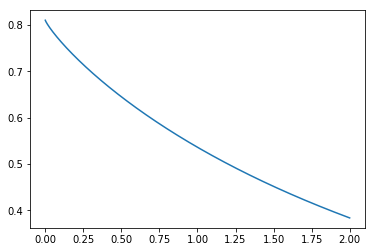

In [267]:
plt.plot(np.linspace(0, 2, 1000), x2['posterior_samples'][10, 1, 1] * bf.weibull_cdf(np.linspace(0, 2, 1000), alpha = x2['posterior_samples'][10, 1, 4], beta = x2['posterior_samples'][10, 1, 5]))

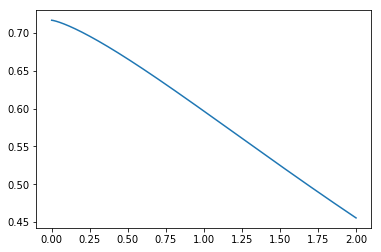

In [268]:
plt.plot(np.linspace(0, 2, 1000), x2['gt'][10, 1] * bf.weibull_cdf(np.linspace(0, 2, 1000), alpha = x2['gt'][10, 4], beta = x2['gt'][10, 5]))

(array([  2.,   0.,   0.,   1.,   1.,   3.,   5.,   7.,   1.,   3.,  10.,
          5.,   7.,   8.,   9.,  16.,  18.,  14.,  22.,  21.,  35.,  39.,
         41.,  54.,  49.,  60.,  68.,  72.,  97., 101., 123., 132., 175.,
        228., 203.,  83.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,  10.,  28.,  43.,  67.,  50.,  62.,  60.,  73.,
         57.,  48.,  40.,  39.,  28.,  28.,  24.,  21.,  20.,  22.,   9.,
         11.,  13.,   5.,   6.,   5.,   4.,   4.,   2.,   0.,   0.,   1.,
          1.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          2.]),
 array([-2.21964145, -2.17164857, -2.1236557 , -2.07566283, -2.02766995,
        -1.97967708, -1.93168421, -1.88369133, -1.83569846, -1.78770559,
        -1.73971272, -1.69171984, -1.64372697, -1.5957341 , -1.54774122,
        -1.49974835, -1.45175548, -1.4037626 , -1.35576973, -1.30777686,
        -1.25978398, -1.21

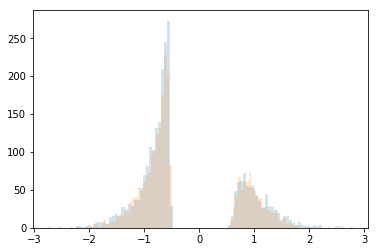

In [269]:
plt.hist(out[0] * out[1], bins = 100, alpha = 0.2)
plt.hist(outp[0] * outp[1], bins = 100, alpha = 0.2)

In [270]:
x2['a_of_t_dist_in'], x2['a_of_t_dist_out'], x2['a_of_t_gt_in'], x2['a_of_t_gt_out'], x2['a_of_t_post_in'], x2['a_of_t_post_out'] = a_of_t_reg_data_prep(mcmc_dict = x2,
                                                                                                                                                   model = 'weibull_cdf',
                                                                                                                                                   n_eval_points = 1000,
                                                                                                                                                   max_t = 20,
#                                                                                                                                                    p_lims = [0.01, 0.99],
                                                                                                                                                   n_posterior_subsample = 10,
                                                                                                                                                   split_ecdf = False,
                                                                                                                                                   bnd_epsilon = 0.05)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [ ]:
 x['a_of_t_gt_in'], x['a_of_t_gt_out'], x['a_of_t_post_in'], x['a_of_t_post_out']

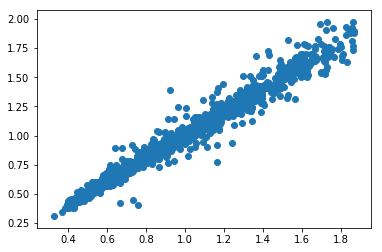

In [271]:
plt.scatter(x2['a_of_t_gt_in'],x2['a_of_t_post_in'])

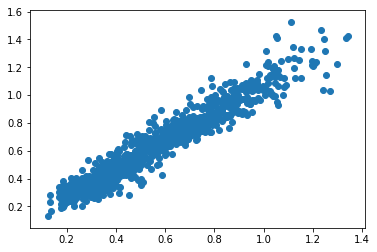

In [272]:
plt.scatter( x2['a_of_t_gt_out'], x2['a_of_t_post_out'])

In [273]:
from sklearn.linear_model import LinearRegression

reg_out = LinearRegression().fit(np.asmatrix(x2['a_of_t_gt_out']).T, np.asmatrix(x2['a_of_t_post_out']).T)
reg_in = LinearRegression().fit(np.asmatrix(x2['a_of_t_gt_in']).T, np.asmatrix(x2['a_of_t_post_in']).T)

In [274]:
reg_out = LinearRegression().fit(np.asmatrix(x2['a_of_t_gt_out']).T, np.asmatrix(x2['a_of_t_post_out']).T)
reg_in = LinearRegression().fit(np.asmatrix(x2['a_of_t_gt_in']).T, np.asmatrix(x2['a_of_t_post_in']).T)

In [275]:
r_out = reg_out.score(np.asmatrix(x2['a_of_t_gt_out']).T, np.asmatrix(x2['a_of_t_post_out']).T)

In [276]:
r_in = reg_in.score(np.asmatrix(x2['a_of_t_gt_in']).T, np.asmatrix(x2['a_of_t_post_in']).T)

In [277]:
r_prime_out = 1/2 * np.log((1 + r_out) / (1 - r_out))
r_prime_in = 1/2 * np.log((1 + r_in) / (1 - r_in))
S = np.sqrt((1 / (1000 - 3) + 1 / (1000 - 3)))
z = np.abs((r_prime_out - r_prime_in) / S)

In [285]:
z

8.776105382886197

In [284]:
B = 10000
r_diff = []
for i in range(B):
    sample = np.random.choice(x2['a_of_t_gt_out'].shape[0] , size = x2['a_of_t_gt_out'].shape[0] ,replace = True)
    r_out_tmp = reg_out.score(np.asmatrix(x2['a_of_t_gt_out'][sample]).T, np.asmatrix(x2['a_of_t_post_out'][sample]).T)
    r_in_tmp = reg_in.score(np.asmatrix(x2['a_of_t_gt_in'][sample]).T, np.asmatrix(x2['a_of_t_post_in'][sample]).T)
    r_diff.append(r_in_tmp - r_out_tmp)
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [286]:
r_diff_cdf = ECDF(r_diff)

In [287]:
np.linspace(0,0.1, 1000)[r_diff_cdf(np.linspace(0,0.1, 1000)) < 0.05][-1]

0.03203203203203203

In [312]:
def a_of_t_panel():

    fig, ax = plt.subplots(2, 
                           2, 
                           figsize = (10, 10), 
                           sharex = False, 
                           sharey = False)

    ax[0, 0].scatter(x2['a_of_t_gt_in'],x2['a_of_t_post_in'], color = 'black', alpha = 0.5)
    ax[0, 0].set_title('Boundary Recovery: At Data', fontsize = 16)
    ax[0, 0].text(0.7, 0.1, 
                  '$R^2$: ' + str(round(r_in,2)), 
                  transform = ax[0, 0].transAxes, 
                  fontsize = 14)
    ax[0, 0].set_xlabel('True', fontsize = 14)
    ax[0, 0].set_ylabel('Recovered', fontsize = 14)
    ax[0, 0].tick_params(labelsize = 12)


    ax[0, 1].scatter(x2['a_of_t_gt_out'], x2['a_of_t_post_out'], color = 'black', alpha = 0.5)
    ax[0, 1].set_title('Boundary Recovery: Out of Data', fontsize = 16)
    ax[0, 1].text(0.7, 0.1,
                 '$R^2$: ' + str(round(r_out, 2)), 
                  transform = ax[0, 1].transAxes, 
                  fontsize = 14)
    ax[0, 1].set_xlabel('True', fontsize = 14)
    ax[0, 1].set_ylabel('Recovered', fontsize = 14)
    ax[0, 1].tick_params(labelsize = 12)


    ax[1, 0].hist(r_diff, density = True, bins = 50, histtype = 'step', color = 'black')
    ax[1, 0].axvline(x = np.linspace(0,0.1, 1000)[r_diff_cdf(np.linspace(0,0.1, 1000)) < 0.05][-1], color = 'red', linestyle = '-.')
    ax[1, 0].axvline(x = np.linspace(0,0.1, 1000)[r_diff_cdf(np.linspace(0,0.1, 1000)) > 0.95][0], color = 'red', linestyle = '-.')
    #ax[1, 0].text(0.14, 30, 'z-score: ' + str(round(z, 2)) , ha = 'center', fontsize = 14)
    ax[1, 0].set_title('Bootstrap Correlation Difference', fontsize = 16)
    ax[1, 0].set_xlim(left = 0.0) #, 0.2)
    mylims_x = ax[1, 0].get_xlim()
    mylims_y = ax[1, 0].get_ylim()
    ax[1, 0].set_xlim(right = mylims_x[1] * 2)
    mylims_x = ax[1, 0].get_xlim()
    #mylims_y = ax[1, 0].get_ylim()
    ax[1, 0].text(mylims_x[0] + (2 / 3) * (mylims_x[1] - mylims_x[0]), mylims_y[0] + (1/2) * (mylims_y[1] - mylims_y[0]), 'z-score: ' + str(round(z, 2)) , ha = 'center', fontsize = 14)
    ax[1, 0].tick_params(axis = 'x', labelrotation = -45) # to Rotate Xticks Label Text
    ax[1, 0].tick_params(labelsize = 12)

    ax[1, 1].set_title(r'$\frac{1}{T} \int_T(GT(t) - Recovered(t))^2 dt$', fontsize = 16)
    ax[1, 1].hist(x2['a_of_t_dist_in'][~np.isnan(x2['a_of_t_dist_in'])], bins = np.linspace(0, 0.5, 100), alpha = 0.2, color = 'red', label = 'At Data', density = True)
    ax[1, 1].hist(x2['a_of_t_dist_out'][~np.isnan(x2['a_of_t_dist_out'])], bins = np.linspace(0, 0.5, 100), alpha = 0.2, color = 'black', label = 'Out of Data', density = True)
    ax[1, 1].tick_params(labelsize = 12)
    ax[1, 1].legend(fontsize = 12)
    #mylims_y = ax[1, 0].get_ylim()
    #mylims_x = ax[1, 0].get_xlim()
    plt.tight_layout()
    plt.show()
    return mylims_y, mylims_x

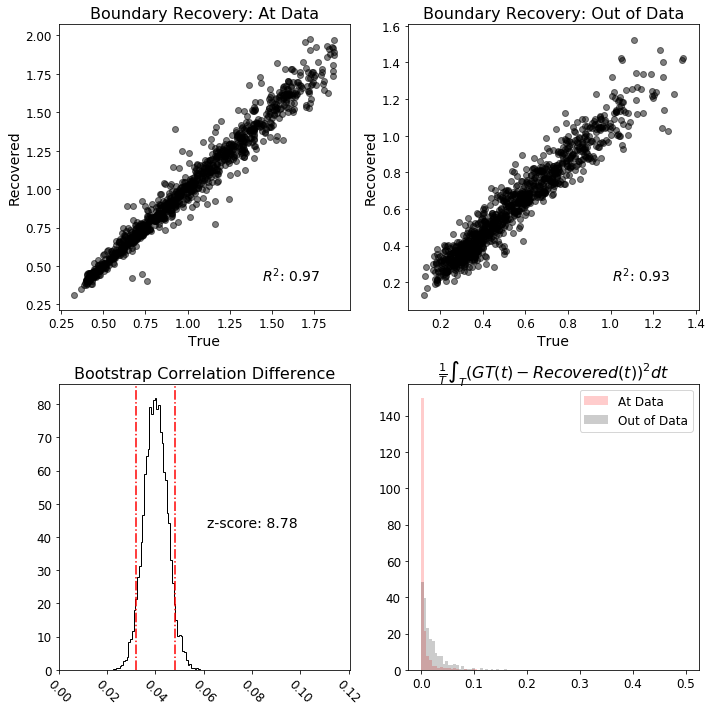

((0.0, 86.08807617060127), (0.0, 0.1204640306800053))

In [313]:
a_of_t_panel()

(array([441., 285., 118.,  48.,  50.,  20.,  12.,   7.,   3.,   2.,   1.,
          1.,   2.,   2.,   2.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00074016, 0.01598864, 0.03123711, 0.04648558, 0.06173406,
        0.07698253, 0.092231  , 0.10747948, 0.12272795, 0.13797642,
        0.1532249 , 0.16847337, 0.18372184, 0.19897032, 0.21421879,
        0.22946726, 0.24471574, 0.25996421, 0.27521269, 0.29046116,
        0.30570963, 0.32095811, 0.33620658, 0.35145505, 0.36670353,
        0.381952  , 0.39720047, 0.41244895, 0.42769742, 0.44294589,
        0.45819437, 0.47344284, 0.48869131, 0.50393979, 0.51918826,
        0.53443673, 0.54968521, 0.56493368, 0.58018215, 0.59543063,
        0.6106791 ]),
 <a list of 40 Patch objects>)

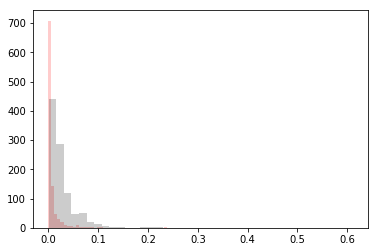

In [170]:
plt.hist(x2['a_of_t_dist_in'][~np.isnan(x['a_of_t_dist_in'])], bins = 40, alpha = 0.2, color = 'red', )
plt.hist(x['a_of_t_dist_out'][~np.isnan(x['a_of_t_dist_out'])], bins = 40, alpha = 0.2, color = 'black', )

In [163]:
r_out = reg = LinearRegression().fit(np.asmatrix(x['a_of_t_gt_out']).T, np.asmatrix(norm_x).T )

ValueError: Found input variables with inconsistent numbers of samples: [200, 1000]

In [ ]:
r_in = reg.score(np.asmatrix(x['a_of_t_gt_out']).T, np.asmatrix(norm_x).T )

In [69]:
np.asmatrix(norm_x).shape

(1, 1000)

In [45]:
x['a_of_t_post_out'].shape

(1000,)

In [47]:
x['a_of_t_gt_out'].shape

(1000,)

In [75]:
reg.score(np.asmatrix(x['a_of_t_gt_out']).T, np.asmatrix(x['a_of_t_post_out']).T)

0.9112401801890077

In [85]:
bf.weibull_cdf(np.linspace(0, 20, 1000), alpha = np.array([1, 2, 3]), beta = np.array([1, 2, 3]))

ValueError: operands could not be broadcast together with shapes (1000,) (3,) 

In [101]:
in_ = np.zeros(100, dtype = np.bool)

In [18]:
x['data']

array([[[0.   , 0.   ],
        [0.423, 0.142],
        [0.247, 0.188],
        ...,
        [0.   , 0.   ],
        [0.   , 0.   ],
        [0.   , 0.   ]],

       [[0.017, 0.   ],
        [0.198, 0.   ],
        [0.134, 0.016],
        ...,
        [0.   , 0.   ],
        [0.   , 0.   ],
        [0.   , 0.   ]],

       [[0.   , 0.   ],
        [0.   , 0.   ],
        [0.   , 0.   ],
        ...,
        [0.   , 0.   ],
        [0.   , 0.   ],
        [0.   , 0.   ]],

       ...,

       [[0.   , 0.   ],
        [0.   , 0.   ],
        [0.   , 0.   ],
        ...,
        [0.   , 0.   ],
        [0.   , 0.   ],
        [0.   , 0.   ]],

       [[0.   , 0.   ],
        [0.   , 0.   ],
        [0.   , 0.   ],
        ...,
        [0.   , 0.   ],
        [0.   , 0.   ],
        [0.   , 0.   ]],

       [[0.   , 0.   ],
        [0.028, 0.   ],
        [0.781, 0.027],
        ...,
        [0.   , 0.   ],
        [0.   , 0.   ],
        [0.   , 0.   ]]])

In [24]:
def a_of_t_histogram(mcmc_dict = None,
                     model = 'None',
                     save = True,
                     data_signature = '',
                     train_data_type = '',
                     method = 'mlp'):
    
    plt.hist(mcmc_dict['a_of_t_dist_out'][ ~np.isnan(mcmc_dict['a_of_t_dist_out'])], 
             bins = 40, 
             alpha = 1,
             color = 'red', 
             histtype = 'step',
             edgecolor = 'red',
             label = 'Out of Data')
    plt.hist(mcmc_dict['a_of_t_dist_in'][ ~np.isnan(mcmc_dict['a_of_t_dist_in'])], 
             bins = 40, 
             alpha = 1.0, 
             color = 'black',
             histtype = 'step',
             edgecolor = 'black',
             label = 'At Data')
    plt.title(model.upper() + ': Boundary RMSE', size = 20)
    plt.legend()
    
    if save == True:
        if machine == 'home':
            fig_dir = "/users/afengler/OneDrive/git_repos/nn_likelihoods/figures/" + method + "/a_of_t"
            if not os.path.isdir(fig_dir):
                os.mkdir(fig_dir)
            
            figure_name = 'a_of_t_plot_'
            plt.savefig(fig_dir + '/' + figure_name + model + data_signature + '_' + train_data_type + '.png', dpi = 300, )
            plt.close()
            return
    else:
        return plt.show()

In [20]:
a_of_t_histogram(mcmc_dict = x,
                 model = 'weibull_cdf',
                 save = False,
                 method = 'mlp')

KeyError: 'a_of_t_dist_out'

In [25]:
x['a_of_t_dist_in'], x['a_of_t_dist_out'] = a_of_t_data_prep(mcmc_dict = x,
                                                             model = 'weibull_cdf',
                                                             n_eval_points = 2000,
                                                             max_t = 20,
                                                             p_lims = [0.01, 0.99],
                                                             n_posterior_subsample = 100,
                                                             split_ecdf = False,
                                                             bnd_epsilon = 0.05)

0
10


/Users/afengler/opt/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/afengler/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


(array([607., 161.,  78.,  32.,  31.,  21.,  16.,  15.,   5.,   5.,   2.,
          4.,   3.,   3.,   2.,   3.,   3.,   2.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.88428837e-04, 3.41654443e-02, 6.81424599e-02, 1.02119475e-01,
        1.36096491e-01, 1.70073506e-01, 2.04050522e-01, 2.38027537e-01,
        2.72004553e-01, 3.05981568e-01, 3.39958584e-01, 3.73935599e-01,
        4.07912615e-01, 4.41889630e-01, 4.75866646e-01, 5.09843662e-01,
        5.43820677e-01, 5.77797693e-01, 6.11774708e-01, 6.45751724e-01,
        6.79728739e-01, 7.13705755e-01, 7.47682770e-01, 7.81659786e-01,
        8.15636801e-01, 8.49613817e-01, 8.83590832e-01, 9.17567848e-01,
        9.51544863e-01, 9.85521879e-01, 1.01949889e+00, 1.05347591e+00,
        1.08745293e+00, 1.12142994e+00, 1.15540696e+00, 1.18938397e+00,
        1.22336099e+00, 1.25733800e+00, 1.29131502e+00, 1.32529203e+00,
      

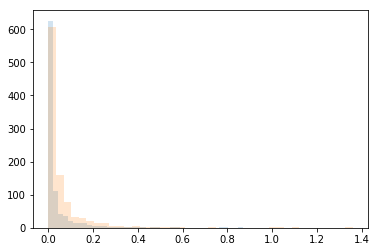

In [150]:
plt.hist(x['a_of_t_dist_in'][~np.isnan(x['a_of_t_dist_in'])], bins = 40, alpha = 0.2, color = 'red', )
plt.hist(x['a_of_t_dist_out'][~np.isnan(x['a_of_t_dist_out'])], bins = 40, alpha = 0.2, color = 'black', )

In [130]:
x['a_of_t_dist_in'][~np.isnan(x['a_of_t_dist_in'])]

array([1.33258586e-02, 1.36633599e-03, 7.30621996e-03, 2.67824998e-03,
       8.49194590e-03, 5.66163628e-03, 6.77958516e-04, 1.53908580e-03,
       3.80662050e-03, 7.90688851e-03, 9.96578262e-02, 1.16104324e-02,
       7.97324279e-03, 5.13453525e-03, 2.03878032e-03, 1.41042441e-02,
       4.00947141e-02, 1.20874617e-02, 1.73246167e-02, 2.67127414e-02,
       3.26430063e-03, 2.42408286e-02, 6.07373855e-03, 2.85209921e-03,
       1.52741315e-02, 9.33852631e-04, 1.82726507e-03, 1.22998353e-03,
       4.51417070e-03, 4.33277249e-03, 4.17699466e-03, 1.14127747e-02,
       3.66789657e-03, 3.70780577e-03, 6.09662485e-03, 1.24775166e-02,
       6.12814615e-03, 3.71614395e-03, 1.30475686e-03, 4.80185589e-03,
       5.93938128e-03, 2.35507539e-02, 1.58107925e-03, 2.79421971e-03,
       9.01226055e-03, 2.07817301e-03, 5.32105011e-02, 1.59578824e-02,
       2.21737577e-02, 1.48144997e-03, 6.51623479e-03, 3.55002289e-03,
       3.87268301e-02, 7.71837302e-03, 5.11673715e-03, 8.35452826e-03,
      

(array([819., 124.,  26.,  21.,   5.,   0.,   1.,   3.,   0.,   1.]),
 array([2.24631517e-05, 1.77305494e-02, 3.54386357e-02, 5.31467220e-02,
        7.08548082e-02, 8.85628945e-02, 1.06270981e-01, 1.23979067e-01,
        1.41687153e-01, 1.59395240e-01, 1.77103326e-01]),
 <a list of 10 Patch objects>)

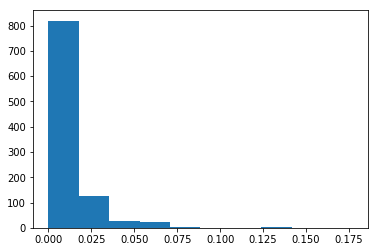

In [89]:
plt.hist(x['a_of_t_dist_out'])

In [66]:
out = cds.ddm_flexbound(v = mcmc_dict['gt'][i, 0],
                        a = mcmc_dict['gt'][i, 1],
                        w = mcmc_dict['gt'][i, 2],
                        ndt = mcmc_dict['gt'][i, 3],
                        delta_t = 0.01, 
                        s = 1,
                        max_t = 20, 
                        n_samples = 20000,
                        boundary_fun = bf.weibull_cdf,
                        boundary_multiplicative = True,
                        boundary_params = {'alpha': mcmc_dict['gt'][i, 4],
                                           'beta': mcmc_dict['gt'][i, 5]})

NameError: name 'mcmc_dict' is not defined

In [114]:
out[0].shape

(20000, 1)

In [115]:
ECDF(out[0][:,0])

In [ ]:
os.listidir(IS_summary_weibull_cdf_N_1024.pickle

In [24]:
out_cdf_0 = ECDF(out[0][out[1] == - 1])
out_cdf_1 = ECDF(out[0][out[1] == 1])

In [27]:
out_cdf_0_eval = out_cdf_0(np.linspace(0, 20, 1000))
out_cdf_1_eval = out_cdf_1(np.linspace(0, 20, 1000))

In [32]:
in_ = (out_cdf_0_eval > 0.01) * (out_cdf_0_eval < 0.99)
out_ = np.invert(in_)

In [72]:
out_ + in_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [34]:
eval_points = np.linspace(0, 20, 1000)

In [40]:
np.mean(np.square(bf.angle(eval_points,theta = 0.5)[in_] - bf.angle(eval_points,theta = 0.4)[in_]))

0.11843808675945207

In [52]:
np.mean(np.mean(  np.square(np.maximum(2 + bf.angle(eval_points,theta = 0.5)[out_], 0) - np.maximum(2 + bf.angle(eval_points,theta = 0.4)[out_], 0)) ) )

0.0026031486737876893

In [53]:
 np.square(np.maximum(2 + bf.angle(eval_points,theta = 0.5)[out_], 0) - np.maximum(2 + bf.angle(eval_points,theta = 0.4)[out_], 0))

array([0.00000000e+00, 6.11403798e-06, 2.44561519e-05, 5.50263418e-05,
       9.78246077e-05, 1.52850950e-04, 2.20105367e-04, 2.99587861e-04,
       3.91298431e-04, 4.95237077e-04, 6.11403798e-04, 7.39798596e-04,
       8.80421469e-04, 1.03327242e-03, 1.19835144e-03, 1.37565855e-03,
       1.56519372e-03, 1.76695698e-03, 1.98094831e-03, 2.20716771e-03,
       2.44561519e-03, 2.69629075e-03, 2.95919438e-03, 3.23432609e-03,
       3.52168588e-03, 3.82127374e-03, 4.13308968e-03, 4.45713369e-03,
       4.79340578e-03, 5.14190594e-03, 5.50263418e-03, 5.87559050e-03,
       6.26077489e-03, 6.65818736e-03, 7.06782791e-03, 7.48969653e-03,
       7.92379322e-03, 8.37011800e-03, 8.82867085e-03, 9.29945177e-03,
       9.78246077e-03, 1.02776978e-02, 1.07851630e-02, 1.13048562e-02,
       1.18367775e-02, 1.23809269e-02, 1.29373044e-02, 1.35059099e-02,
       1.40867435e-02, 1.46798052e-02, 1.52850950e-02, 1.59026128e-02,
       1.65323587e-02, 1.71743327e-02, 1.78285348e-02, 1.84949649e-02,
      

In [49]:
np.maximum(bf.angle(eval_points,theta = 0.5)[out_], 0)

array([-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [50]:
bf.angle(eval_points,theta = 0.5)[out_]

array([ -0.        ,  -0.01093699,  -0.02187397,  -0.03281096,
        -0.04374795,  -0.05468493,  -0.06562192,  -0.07655891,
        -0.08749589,  -0.09843288,  -0.10936987,  -0.12030685,
        -0.13124384,  -0.14218083,  -0.15311781,  -0.1640548 ,
        -0.17499179,  -0.18592878,  -0.19686576,  -0.20780275,
        -0.21873974,  -0.22967672,  -0.24061371,  -0.2515507 ,
        -0.26248768,  -0.27342467,  -0.28436166,  -0.29529864,
        -0.30623563,  -0.31717262,  -0.3281096 ,  -0.33904659,
        -0.34998358,  -0.36092056,  -0.37185755,  -0.38279454,
        -0.39373152,  -0.40466851,  -0.4156055 ,  -0.42654248,
        -0.43747947,  -0.44841646,  -0.45935344,  -0.47029043,
        -0.48122742,  -0.49216441,  -0.50310139,  -0.51403838,
        -0.52497537,  -0.53591235,  -0.54684934,  -0.55778633,
        -0.56872331,  -0.5796603 ,  -0.59059729,  -0.60153427,
        -0.61247126,  -0.62340825,  -0.63434523,  -0.64528222,
        -0.65621921,  -0.66715619,  -0.67809318,  -0.68

In [13]:
x = np.random.normal(size = 1000) 
x_cdf = ECDF(x)

In [18]:
x_cdf(0.0)

0.487

In [21]:
x_cdf(np.linspace(0, 1, 100))

array([0.487, 0.492, 0.499, 0.5  , 0.502, 0.506, 0.51 , 0.516, 0.522,
       0.525, 0.525, 0.529, 0.531, 0.536, 0.538, 0.54 , 0.542, 0.547,
       0.551, 0.557, 0.561, 0.563, 0.567, 0.569, 0.571, 0.573, 0.577,
       0.582, 0.59 , 0.591, 0.594, 0.601, 0.605, 0.607, 0.61 , 0.616,
       0.619, 0.624, 0.626, 0.632, 0.634, 0.634, 0.639, 0.644, 0.645,
       0.647, 0.653, 0.655, 0.657, 0.663, 0.67 , 0.673, 0.674, 0.677,
       0.679, 0.68 , 0.685, 0.686, 0.69 , 0.693, 0.694, 0.695, 0.7  ,
       0.702, 0.704, 0.709, 0.709, 0.717, 0.718, 0.72 , 0.723, 0.727,
       0.731, 0.735, 0.738, 0.742, 0.746, 0.75 , 0.753, 0.756, 0.761,
       0.764, 0.767, 0.77 , 0.773, 0.774, 0.777, 0.78 , 0.782, 0.785,
       0.787, 0.792, 0.797, 0.802, 0.804, 0.806, 0.808, 0.811, 0.813,
       0.818])

In [252]:
(1,)[0]

1

In [212]:
import kde_info

In [215]:
x = kde_info.temp

In [219]:
#x

In [220]:
param_bounds = x['ddm']['param_bounds_network'] + x['ddm']['boundary_param_bounds_network']

[[-3.0, 3.0], [0.3, 2.5], [0.1, 0.9], [0.0, 2.0]]

In [227]:
bounds = [[i[0] for i in  param_bounds], [i[1] for i in  param_bounds]]

In [237]:
np.stack([np.random.uniform(low = bounds[0], high = bounds[1]) for i in range(100)])

array([[ 0.44524397,  0.76234082,  0.37651613,  1.84556165],
       [-1.52449251,  0.79031087,  0.28449276,  1.99840051],
       [-2.76235844,  1.51309817,  0.50808862,  1.08631735],
       [ 2.64559078,  2.01424065,  0.83617154,  1.17889445],
       [-2.48103207,  1.73562785,  0.74040418,  1.33860833],
       [-0.55533605,  0.56746907,  0.38665119,  0.49000592],
       [-0.19563899,  2.13323768,  0.62821171,  1.99384363],
       [ 0.45312707,  0.49547774,  0.20110256,  0.57315236],
       [ 2.95902972,  0.45384035,  0.42219785,  1.58150862],
       [ 0.26376415,  0.65957714,  0.37782415,  0.41363304],
       [ 1.05638602,  0.83551228,  0.44972194,  0.39704634],
       [ 1.5934926 ,  0.71419533,  0.66160518,  1.03662345],
       [-2.77084804,  0.91409527,  0.32598216,  0.40680127],
       [ 1.76766061,  1.69120541,  0.28260972,  0.93287897],
       [ 2.96317726,  1.77248246,  0.28401883,  1.40867371],
       [-1.77435772,  1.07414329,  0.20304277,  0.62484086],
       [ 0.35302586,  1.

In [ ]:
param_bounds

In [222]:
bounds_low = [i[0] for i in  param_bounds]
# bounds_high = param_bounds[]

In [238]:
x = np.zeros((10, 6))

In [242]:
x.tolist()

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [ ]:
theta_tuple = [(np.random.uniform(low = self.config['param_bounds'][0], 
                                    high = self.config['param_bounds'][1])) for i in range(self.config['nparamsets'])]
        

In [ ]:
#kde_info.temp